<a href="https://colab.research.google.com/github/Daniel-Muruthi/lagos_air_pollution/blob/master/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Air Pollution and Respiratory Disease Analytics — Lagos case study**

# Project Overview
This project analyzes the relationship between air pollution and respiratory diseases in Lagos, Nigeria — Africa's most populous city with **>20 million** people.

## Objectives
1. Derive a **pollution index** (composite feature of all pollutants)  
2. Monitor air pollution trends over time  
3. Analyze relationship between pollution spikes and hospital respiratory cases  
4. Predict respiratory disease surges using pollution data  
5. Identify high-risk cities, periods, and pollutants  
6. Recommend public health and urban environmental policies  

## Hypotheses to Test
- **H1:** Higher **PM2.5** levels correlate with more respiratory hospital cases  
- **H2:** Cities with higher **industrial indices** have worse air quality  
- **H3:** **Harmattan** season shows spikes in **PM10** and respiratory cases  
- **H4:** Weather conditions (low humidity, high temperatures) worsen pollution impact


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

## **Data Loading and Initial Inspection**

In [4]:
# Load the datasets

df1 = pd.read_excel("lagos_air_pollution_health_data.xlsx")
df2 = pd.read_excel("lagos_air_pollution_health_data_1.xlsx")

In [5]:
# Check out the shape of our datasets

print(f"Dataset 1 shape: {df1.shape}")
print(f"Dataset 2 shape: {df2.shape}")

Dataset 1 shape: (258420, 17)
Dataset 2 shape: (258420, 16)


In [6]:
# Examine the feature names differences

print("\nDataset 1 columns:", df1.columns.tolist())
print("Dataset 2 columns:", df2.columns.tolist())


Dataset 1 columns: ['City', 'date', 'pm2_5', 'pm10', 'no2', 'so2', 'Unnamed: 6', 'o3', 'hospital_id', 'respiratory_cases', 'avg_age_of_patients', 'weather_temperature', 'weather_humidity', 'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index']
Dataset 2 columns: ['C', 'date', 'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'hospital_id', 'respiratory_cases', 'avg_age_of_patients', 'weather_temperature', 'weather_humidity', 'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index']


In [7]:
# Display first five observations of our first dataset

df1.head()

City       date  pm2_5   pm10    no2    so2  Unnamed: 6     o3  \
0  AJAH 2021-01-01  39.86  98.09  54.93  29.68       29.68  46.00   
1  AJAH 2021-01-01  68.06  80.35  58.54  33.05       33.05  48.53   
2  AJAH 2021-01-01  77.60  76.60  58.08  25.11       25.11  17.85   
3  AJAH 2021-01-01  90.22  98.94  74.46  19.47       19.47  35.27   
4  AJAH 2021-01-01  85.23  95.18  40.59  14.81       14.81  52.23   

   hospital_id  respiratory_cases  avg_age_of_patients  weather_temperature  \
0  HOSP_AJA_10               14.0                 48.0                 27.7   
1   HOSP_AJA_6               16.0                 44.9                 25.9   
2  HOSP_AJA_10                9.0                 22.7                 27.9   
3   HOSP_AJA_7               12.0                 41.4                 28.9   
4   HOSP_AJA_3               17.0                 37.0                 32.4   

   weather_humidity  wind_speed  rainfall_mm  population_density  \
0              60.0         1.0          9.3             13683.2   
1              52.4         3.2          5.0             15838.7   
2              51.9         3.2          8.4             17918.3   
3              73.6         3.8          0.3             28635.0   
4              70.4         2.2         10.0             24057.7   

   industrial_activity_index  
0                       0.77  
1                       0.27  
2                       0.30  
3                       0.51  
4                       0.77

In [8]:
# Display first five observations of our second dataset

df2.head()

C       date  pm2_5    pm10    no2    so2     o3 hospital_id  \
0  I K E J A 2021-01-01  65.64  135.39  45.21  22.29  34.84  HOSP_IKE_1   
1      Ikeja 2021-01-01  76.49  116.65  50.01  10.20  32.19  HOSP_IKE_4   
2  I K E J A 2021-01-01  55.50  101.72  39.10  21.91  49.99  HOSP_IKE_1   
3      Ikeja 2021-01-01  56.37  138.53  46.40  28.13  24.89  HOSP_IKE_8   
4  I K E J A 2021-01-01  93.77  123.73  59.55  11.82  29.73  HOSP_IKE_3   

   respiratory_cases  avg_age_of_patients  weather_temperature  \
0               16.0                 44.0                 25.1   
1               12.0                 33.1                 25.3   
2               20.0                 33.5                 27.7   
3               15.0                 49.3                 32.8   
4               20.0                 45.4                 27.9   

   weather_humidity  wind_speed  rainfall_mm  population_density  \
0              40.0         3.1          2.2             22937.7   
1              53.5         3.8          2.2             21787.8   
2              72.3         4.7          1.0             14798.0   
3              62.9         4.8          8.2             18013.6   
4              64.8         3.4          9.1             25980.3   

   industrial_activity_index  
0                       0.87  
1                       0.32  
2                       0.78  
3                       0.24  
4                       0.30

In [9]:
# Display basic dataset overview information of our first dataset

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258420 entries, 0 to 258419
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   City                       258392 non-null  object        
 1   date                       258397 non-null  datetime64[ns]
 2   pm2_5                      258417 non-null  float64       
 3   pm10                       258411 non-null  float64       
 4   no2                        258419 non-null  float64       
 5   so2                        258412 non-null  float64       
 6   Unnamed: 6                 258412 non-null  float64       
 7   o3                         258413 non-null  float64       
 8   hospital_id                258418 non-null  object        
 9   respiratory_cases          258413 non-null  float64       
 10  avg_age_of_patients        258404 non-null  float64       
 11  weather_temperature        258416 non-null  float64 

In [10]:
# Display basic dataset overview information of our second dataset

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258420 entries, 0 to 258419
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   C                          258392 non-null  object        
 1   date                       258397 non-null  datetime64[ns]
 2   pm2_5                      258417 non-null  float64       
 3   pm10                       258411 non-null  float64       
 4   no2                        258419 non-null  float64       
 5   so2                        258412 non-null  float64       
 6   o3                         258413 non-null  float64       
 7   hospital_id                258418 non-null  object        
 8   respiratory_cases          258413 non-null  float64       
 9   avg_age_of_patients        258404 non-null  float64       
 10  weather_temperature        258416 non-null  float64       
 11  weather_humidity           258414 non-null  float64 

In [11]:
# Checking for duplicates in the first dataset

df1.duplicated().sum()

np.int64(0)

In [12]:
# Checking for duplicates in the second dataset

df2.duplicated().sum()

np.int64(0)

In [13]:
# Checking for missing values in first dataset

df1.isna().sum()

City                         28
date                         23
pm2_5                         3
pm10                          9
no2                           1
so2                           8
Unnamed: 6                    8
o3                            7
hospital_id                   2
respiratory_cases             7
avg_age_of_patients          16
weather_temperature           4
weather_humidity              6
wind_speed                    4
rainfall_mm                   3
population_density           22
industrial_activity_index     5
dtype: int64

In [14]:
# Checking for missing values in second dataset

df2.isna().sum()

C                            28
date                         23
pm2_5                         3
pm10                          9
no2                           1
so2                           8
o3                            7
hospital_id                   2
respiratory_cases             7
avg_age_of_patients          16
weather_temperature           4
weather_humidity              6
wind_speed                    4
rainfall_mm                   3
population_density           22
industrial_activity_index     5
dtype: int64

## **Data Cleaning and PreProcessing**

In [15]:
def wrangle(first_dataset, second_dataset):
    """
    Clean our data
    """

    # Create a copy to avoid modifying original
    df1 = first_dataset.copy()
    df2 = second_dataset.copy()

    # Fix column naming issues by lowercasing all letters and removing any leading and trailing white spaces
    df1.columns = df1.columns.str.lower().str.strip()
    df2.columns = df2.columns.str.lower().str.strip()

    # Renaming inconsistent columns in both datasets
    df2.rename(columns={'c': 'city'}, inplace=True)

    # Remove 'unnamed: 6' column from df1 as it appears to be duplicate of so2
    df1.drop('unnamed: 6', axis=1, inplace=True)

    # Combine both datasets
    df_combined = pd.concat([df1, df2], ignore_index=True)

    # Clean city names (converts all city names to uppercase, removes leading or trailing whitespaces
    # Replaces multiple consecutive whitespaces in city names with single space
    df_combined['city'] = df_combined['city'].str.upper().str.strip()
    df_combined['city'] = df_combined['city'].str.replace(r'\s+', '', regex=True)

    # Hospital id: ensure all values are string and there are no leading or trailing whitespaces
    df_combined['hospital_id'] = df_combined['hospital_id'].astype(str).str.strip()

    # Handling Missing Values

    # For numerical columns, use median imputation because the median is far more robust to outliers and skewed distributions,
    # which pollution data almost always has (rare extreme spikes)
    # We'll try to fill the median per city if possible
    numerical_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'o3', 'respiratory_cases',
                     'avg_age_of_patients', 'weather_temperature', 'weather_humidity',
                     'wind_speed', 'rainfall_mm', 'population_density', 'industrial_activity_index']

    for col in numerical_cols:
        if df_combined[col].isnull().sum() > 0:
            # attempt per-city median
            try:
                df_combined[col] = df_combined.groupby('city')[col].apply(lambda x: x.fillna(x.median()))
            except Exception:
                df_combined[col] = df_combined[col].fillna(df_combined[col].median())

    # Handling Missing Values For categorical columns
    df_combined['hospital_id'] = df_combined['hospital_id'].fillna('UNKNOWN')

    # Populate empty city rows
    # Define mapping of code to city name
    city_mapping = {
        'AJA': 'AJAH',
        'IKE': 'IKEJA',
        'LEK': 'LEKKI',
        'SUR': 'SURULERE',
        'YAB': 'YABA',
    }

    # Extract city codes from hospital_id column
    df_combined['city_code'] = df_combined['hospital_id'].str.extract(r'_([A-Z]{3})_')

    # Map the extracted city codes to the full city names
    df_combined['mapped_city'] = df_combined['city_code'].map(city_mapping)

    # Fill empty cities
    df_combined['city'] = df_combined['city'].replace('', np.nan).combine_first(df_combined['mapped_city'])

    # Drop extra columns
    df_combined.drop(columns=['city_code', 'mapped_city'], inplace=True)

    # Handling Missing Values in our date column
    # Convert date column to datetime format and handle invalid or malformed dates
    df_combined['date'] = pd.to_datetime(df_combined['date'], errors='coerce')
    # Forward fill rows with missing dates
    df_combined['date'] = df_combined['date'].ffill()

    # Remove duplicates
    df_combined.drop_duplicates(inplace=True)

    return df_combined

In [16]:
# Apply data cleaning to our datasets

df = wrangle(df1, df2)
df.head()

city       date  pm2_5   pm10    no2    so2     o3  hospital_id  \
0  AJAH 2021-01-01  39.86  98.09  54.93  29.68  46.00  HOSP_AJA_10   
1  AJAH 2021-01-01  68.06  80.35  58.54  33.05  48.53   HOSP_AJA_6   
2  AJAH 2021-01-01  77.60  76.60  58.08  25.11  17.85  HOSP_AJA_10   
3  AJAH 2021-01-01  90.22  98.94  74.46  19.47  35.27   HOSP_AJA_7   
4  AJAH 2021-01-01  85.23  95.18  40.59  14.81  52.23   HOSP_AJA_3   

   respiratory_cases  avg_age_of_patients  weather_temperature  \
0               14.0                 48.0                 27.7   
1               16.0                 44.9                 25.9   
2                9.0                 22.7                 27.9   
3               12.0                 41.4                 28.9   
4               17.0                 37.0                 32.4   

   weather_humidity  wind_speed  rainfall_mm  population_density  \
0              60.0         1.0          9.3             13683.2   
1              52.4         3.2          5.0             15838.7   
2              51.9         3.2          8.4             17918.3   
3              73.6         3.8          0.3             28635.0   
4              70.4         2.2         10.0             24057.7   

   industrial_activity_index  
0                       0.77  
1                       0.27  
2                       0.30  
3                       0.51  
4                       0.77

In [17]:
# Display basic dataset overview of our cleaned dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271682 entries, 0 to 516754
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   city                       271682 non-null  object        
 1   date                       271682 non-null  datetime64[ns]
 2   pm2_5                      271682 non-null  float64       
 3   pm10                       271682 non-null  float64       
 4   no2                        271682 non-null  float64       
 5   so2                        271682 non-null  float64       
 6   o3                         271682 non-null  float64       
 7   hospital_id                271682 non-null  object        
 8   respiratory_cases          271682 non-null  float64       
 9   avg_age_of_patients        271682 non-null  float64       
 10  weather_temperature        271682 non-null  float64       
 11  weather_humidity           271682 non-null  float64      

In [18]:
# Statistical summary

df.describe()

date          pm2_5           pm10  \
count                         271682  271682.000000  271682.000000   
mean   2022-07-02 03:54:38.694944256      61.396676      92.174295   
min              2021-01-01 00:00:00       0.000000       0.000000   
25%              2021-10-02 00:00:00      49.940000      76.570000   
50%              2022-07-02 00:00:00      60.680000      91.090000   
75%              2023-04-02 00:00:00      72.080000     106.630000   
max              2023-12-31 00:00:00     149.320000     207.330000   
std                              NaN      16.752988      22.841213   

                 no2            so2             o3  respiratory_cases  \
count  271682.000000  271682.000000  271682.000000      271682.000000   
mean       40.975480      15.354797      30.729023          12.858482   
min         0.000000       0.000000       0.000000           1.000000   
25%        33.330000      11.660000      24.670000          10.000000   
50%        40.500000      15.180000      30.390000          13.000000   
75%        48.100000      18.850000      36.400000          15.000000   
max       100.250000      43.940000      79.640000          34.000000   
std        11.177474       5.396274       8.845054           3.807960   

       avg_age_of_patients  weather_temperature  weather_humidity  \
count        271682.000000        271682.000000     271682.000000   
mean             35.028600            29.999332         59.971996   
min              20.000000            25.000000         40.000000   
25%              27.500000            27.500000         50.000000   
50%              35.000000            30.000000         60.000000   
75%              42.600000            32.500000         70.000000   
max              50.000000            35.000000         80.000000   
std               8.665672             2.891213         11.548796   

          wind_speed    rainfall_mm  population_density  \
count  271682.000000  271682.000000       271682.000000   
mean        3.000179       4.996290        20007.085187   
min         1.000000       0.000000        10000.100000   
25%         2.000000       2.500000        15014.625000   
50%         3.000000       5.000000        20002.650000   
75%         4.000000       7.500000        25011.825000   
max         5.000000      10.000000        29999.900000   
std         1.153751       2.891088         5770.966631   

       industrial_activity_index  
count              271682.000000  
mean                    0.550331  
min                     0.200000  
25%                     0.380000  
50%                     0.550000  
75%                     0.730000  
max                     0.900000  
std                     0.202078

In [19]:
# Basic information about our dataset

print(f"\nUnique cities: {df['city'].unique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total hospitals: {df['hospital_id'].nunique()}")
print(f"Cleaned dataset shape: {df.shape}")


Unique cities: ['AJAH' 'IKEJA' 'LEKKI' 'SURULERE' 'YABA']
Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
Total hospitals: 51
Cleaned dataset shape: (271682, 16)


### **Duplicate Analysis**

#### Dealing with the data collection/quality issue where multiple rows have the same city, same date, same hospital but different values
#### for avg_age_of_patients, population_density, and even pollution readings.


In [20]:
# Check combinations that should be unique but aren't

city_date_hosp_counts = df.groupby(['city', 'date', 'hospital_id']).size().reset_index(name='count')
duplicated_city_dates_hosp = city_date_hosp_counts[city_date_hosp_counts['count'] > 1]

print(f"City-Date-Hospital combinations: {len(city_date_hosp_counts)}")
print(f"Duplicated City-Date-Hospital combinations: {len(duplicated_city_dates_hosp)}")
print(f"Percentage of duplicated combinations: {len(duplicated_city_dates_hosp)/len(city_date_hosp_counts)*100:.1f}%")

City-Date-Hospital combinations: 61961
Duplicated City-Date-Hospital combinations: 55399
Percentage of duplicated combinations: 89.4%


In [21]:
# View sample of problematic combinations

sample_duplicates = duplicated_city_dates_hosp.head()
sample_duplicates

city       date  hospital_id  count
1  AJAH 2021-01-01  HOSP_AJA_10      5
2  AJAH 2021-01-01   HOSP_AJA_2      3
3  AJAH 2021-01-01   HOSP_AJA_3      3
4  AJAH 2021-01-01   HOSP_AJA_4      3
5  AJAH 2021-01-01   HOSP_AJA_5      4

In [22]:
# Extract duplicated city-date-hospital combinations
duplicated_pairs = list(zip(duplicated_city_dates_hosp['city'], duplicated_city_dates_hosp['date'], duplicated_city_dates_hosp['hospital_id']))

# Filter full original data for these duplicated pairs
duplicated_records = df[df.apply(lambda row: (row['city'], row['date'], row['hospital_id']) in duplicated_pairs, axis=1)]

# Sort by city, date, hospital_id to cluster duplicates together
duplicated_records_sorted = duplicated_records.sort_values(['city', 'date', 'hospital_id'])

duplicated_records_sorted.head(10)

city       date  pm2_5    pm10    no2    so2     o3  hospital_id  \
0       AJAH 2021-01-01  39.86   98.09  54.93  29.68  46.00  HOSP_AJA_10   
2       AJAH 2021-01-01  77.60   76.60  58.08  25.11  17.85  HOSP_AJA_10   
25      AJAH 2021-01-01  73.02  138.58  43.06  22.76  47.38  HOSP_AJA_10   
258541  AJAH 2021-01-01  99.39   86.50  41.67  18.00  46.10  HOSP_AJA_10   
258550  AJAH 2021-01-01  51.32   96.89  50.63  11.39  54.77  HOSP_AJA_10   
20      AJAH 2021-01-01  27.36   83.28  52.27  10.30  31.27   HOSP_AJA_2   
23      AJAH 2021-01-01  88.34  115.34  60.09  18.31  47.56   HOSP_AJA_2   
24      AJAH 2021-01-01  86.69  130.99  50.43  24.98  26.76   HOSP_AJA_2   
4       AJAH 2021-01-01  85.23   95.18  40.59  14.81  52.23   HOSP_AJA_3   
15      AJAH 2021-01-01  66.66  127.33  39.35  10.08  31.25   HOSP_AJA_3   

        respiratory_cases  avg_age_of_patients  weather_temperature  \
0                    14.0                 48.0                 27.7   
2                     9.0                 22.7                 27.9   
25                   10.0                 40.4                 27.0   
258541               14.0                 27.5                 31.5   
258550                9.0                 33.6                 28.7   
20                    8.0                 30.8                 34.9   
23                   27.0                 25.1                 31.5   
24                   14.0                 33.8                 32.9   
4                    17.0                 37.0                 32.4   
15                    7.0                 30.7                 32.9   

        weather_humidity  wind_speed  rainfall_mm  population_density  \
0                   60.0         1.0          9.3             13683.2   
2                   51.9         3.2          8.4             17918.3   
25                  64.6         2.9         10.0             17460.4   
258541              46.9         1.8          3.9             17619.5   
258550              52.8         1.6          0.4             25521.2   
20                  44.5         1.9          1.7             15787.4   
23                  42.7         1.3          9.1             12619.0   
24                  52.5         1.7          9.8             26808.0   
4                   70.4         2.2         10.0             24057.7   
15                  52.2         4.9          3.5             16811.5   

        industrial_activity_index  
0                            0.77  
2                            0.30  
25                           0.21  
258541                       0.75  
258550                       0.32  
20                           0.69  
23                           0.39  
24                           0.33  
4                            0.77  
15                           0.87

## **Feature Engineering**

In [23]:
# Composite Pollution Index as average of all pollutants (pm2_5, pm10, no2, so2, o3)

# Pollution Indexes
pollutants = [p for p in ['pm2_5','pm10','no2','so2','o3'] if p in df.columns]

# Raw mean (for EDA)
if pollutants:
    df['pollution_index_raw'] = df[pollutants].mean(axis=1)

In [24]:
# Add time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['quarter'] = df['date'].dt.quarter

# Create season feature
# month-based season mapping tuned for Lagos (coastal southern Nigeria)
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Harmattan'    # peak Harmattan months
    elif month in [4,5,6,7,8,9,10]:
        return 'Rainy'        # main rainy season
    else:
        return 'Dry'          # November and March are typically dry transitional months

# apply
if 'season_monthly' not in df.columns:
    df['season_monthly'] = df['month'].apply(season_from_month)

In [25]:
# city-day-hospital aggregation (one row per hospital_id,city per day) - useful for most trend analyses
agg_cols_mean = pollutants + ['pollution_index_raw','weather_temperature','weather_humidity','wind_speed',
                              'avg_age_of_patients','industrial_activity_index','population_density']
# keep only cols that exist
agg_dict = {c: 'mean' for c in agg_cols_mean}
agg_dict.update({
    'respiratory_cases': 'sum',
    'rainfall_mm': 'sum',
    'season_monthly': 'first',  # categorical
    'year': 'first',
    'month': 'first',
    'day_of_year': 'first',
    'quarter': 'first'
})
# Aggregating data by date, city and hospital_id
df = df.groupby(['city', 'date', 'hospital_id'], as_index=False).agg(agg_dict)
df = df.sort_values(['city', 'date', 'hospital_id']).reset_index(drop=True)

print("city-day rows:", len(df))

city-day rows: 61961


## **Exploratory Data Analysis**

In [26]:
# Set plot styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### **1. Pollution trends over time by city (Using daily city aggregated data)**

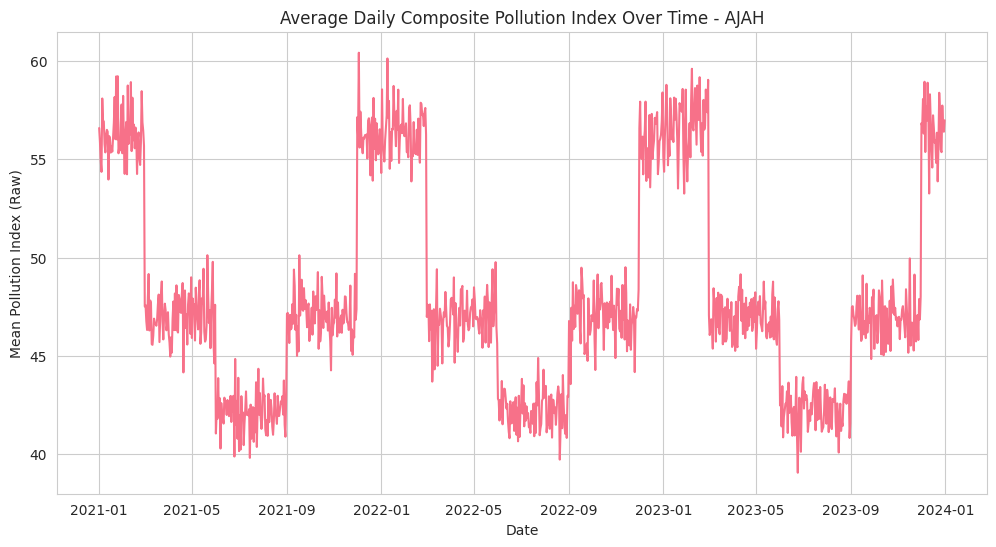

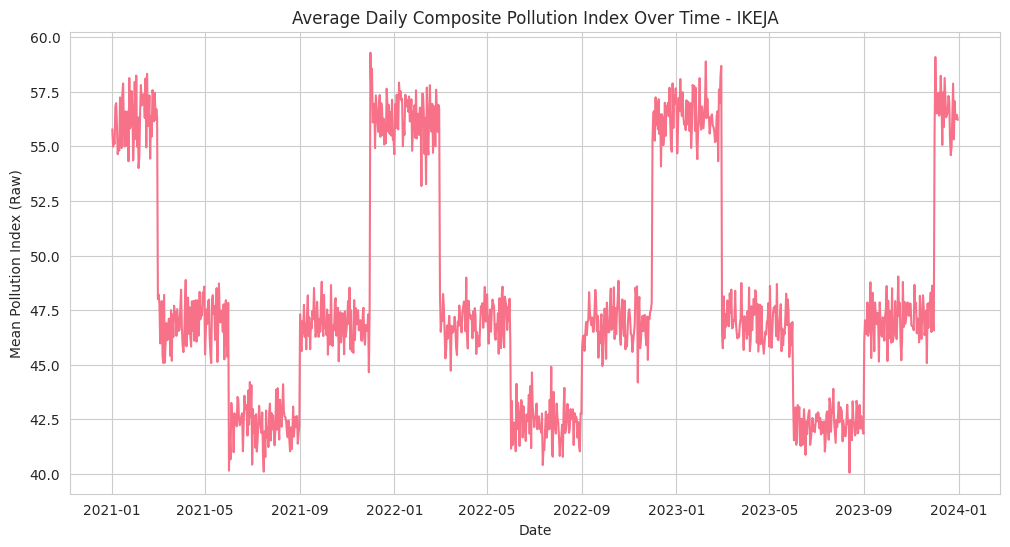

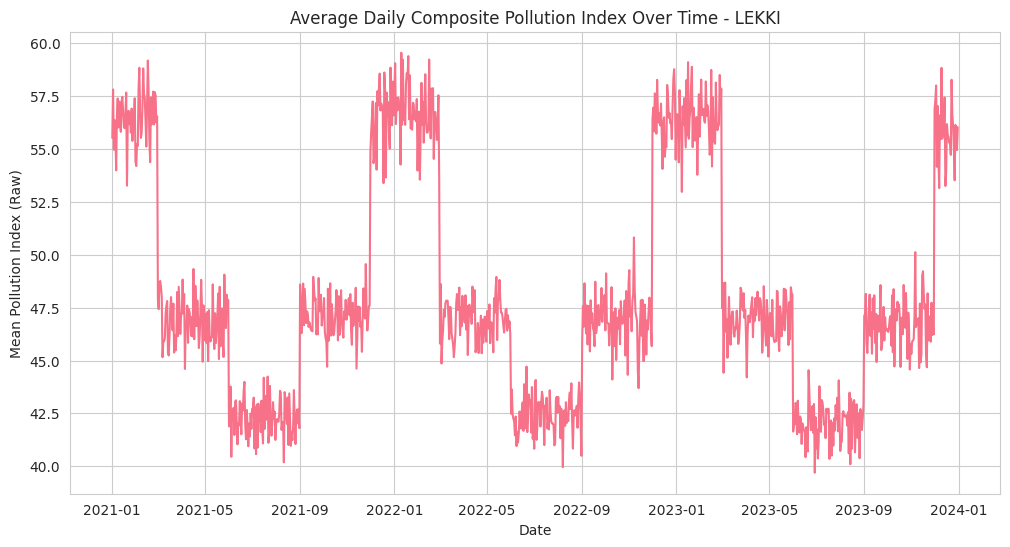

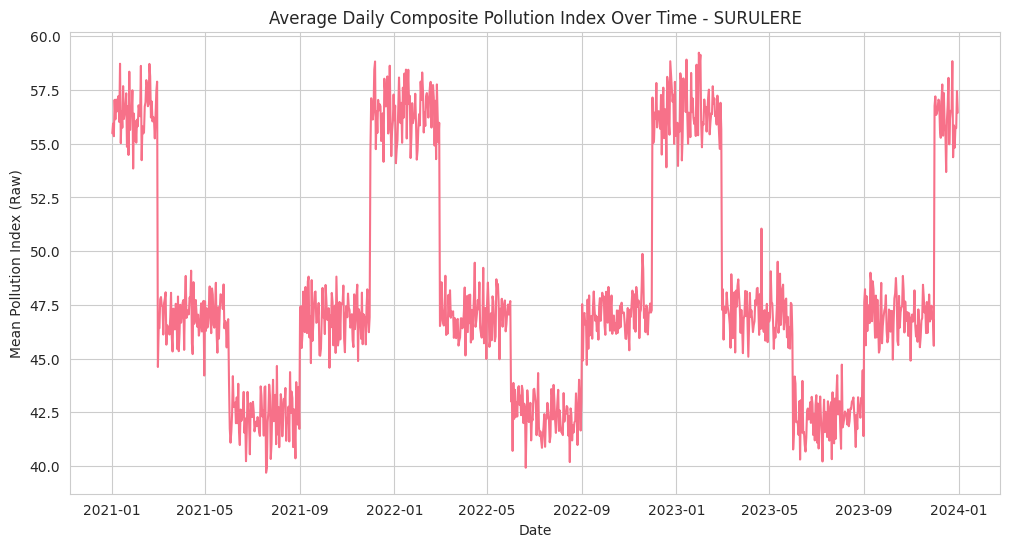

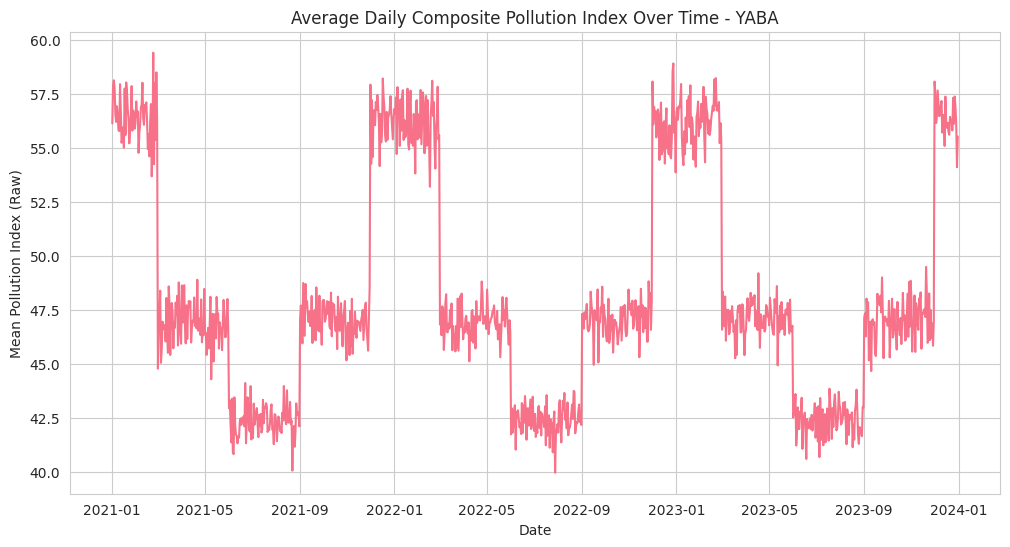

In [27]:
# Get unique cities from your dataset (can use df or cityday)
unique_cities = df['city'].unique()

# Loop through each city and plot pollution index trend
for city in unique_cities:
    city_data = df[df['city'] == city]

    plt.figure(figsize=(12,6))
    sns.lineplot(data=city_data, x='date', y='pollution_index_raw', estimator='mean', ci=None)
    plt.title(f'Average Daily Composite Pollution Index Over Time - {city}')
    plt.xlabel('Date')
    plt.ylabel('Mean Pollution Index (Raw)')
    plt.show()

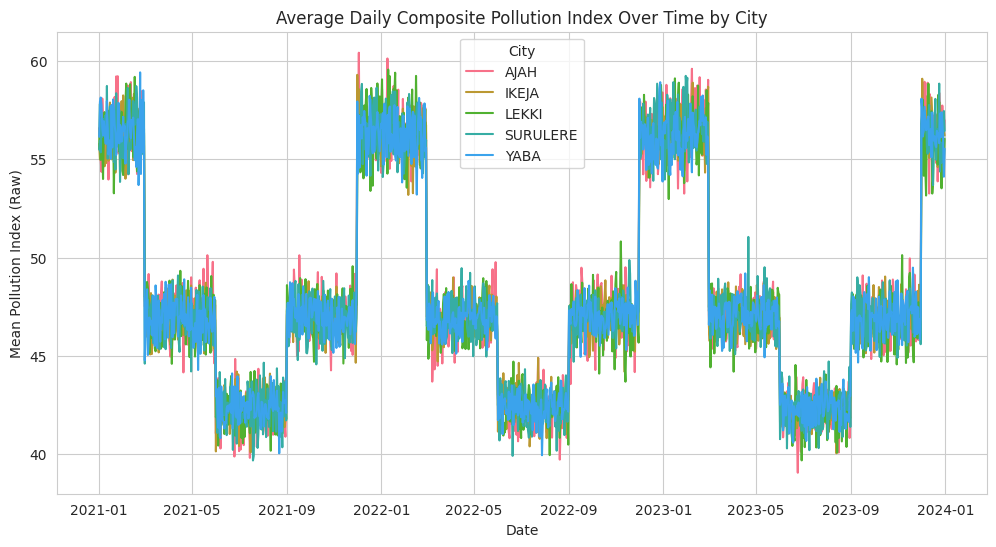

In [28]:
# For all cities

plt.figure()
sns.lineplot(data=df, x='date', y='pollution_index_raw', hue='city', estimator='mean', ci=None)
plt.title('Average Daily Composite Pollution Index Over Time by City')
plt.xlabel('Date')
plt.ylabel('Mean Pollution Index (Raw)')
plt.legend(title='City')
plt.show();

#### **Clear Seasonal Patterns**
All five Lagos districts (**YABA, SURULERE, LEKKI, IKEJA, and AJAH**) show remarkably consistent seasonal pollution cycles:

- **High Pollution Periods (December–March):**  
  Pollution index peaks around **55–60**, corresponding to the **Harmattan season**.
- **Low Pollution Periods (June–September):**  
  Index drops to **40–45**, likely during the **rainy season** when precipitation helps clear pollutants from the atmosphere.

---

#### **District-Level Similarities**
Despite being different areas of Lagos, all districts show nearly identical pollution patterns, suggesting:

- City-wide **meteorological influences** (Harmattan dust, rainfall patterns)  
- **Similar pollution sources** across the metropolitan area  
- Effective **mixing of air masses** across the city  

---

#### **Trend Analysis**
- **Year-over-Year Consistency:** The seasonal pattern repeats reliably across 2021–2024, indicating stable climatic and pollution source influences.  
- **Peak Intensity:** Pollution spikes are quite dramatic — roughly **40% higher** during dry season peaks compared to wet season lows.  

---

#### **Implications for our Research**
These patterns strongly support several of the hypotheses:
- **H3 confirmed:** Clear Harmattan season spikes in pollution  
- **H4 partially supported:** Seasonal variation suggests **weather conditions (humidity, temperature)** significantly impact pollution levels  


### **2. Seasonal patterns of pollution indexed by season and month**

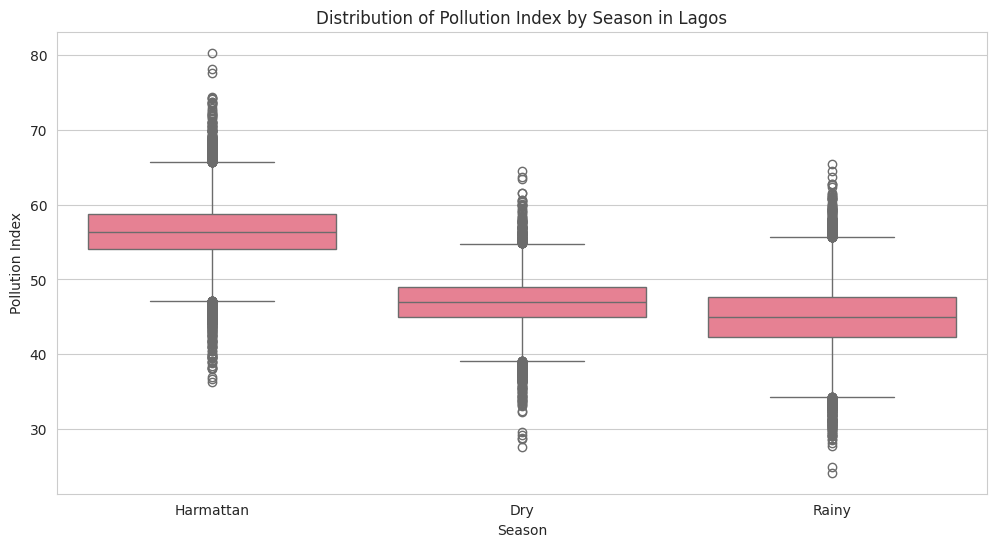

In [29]:
# By season

plt.figure()
sns.boxplot(x='season_monthly', y='pollution_index_raw', data=df, order=['Harmattan', 'Dry', 'Rainy'])
plt.title('Distribution of Pollution Index by Season in Lagos')
plt.xlabel('Season')
plt.ylabel('Pollution Index')
plt.show()


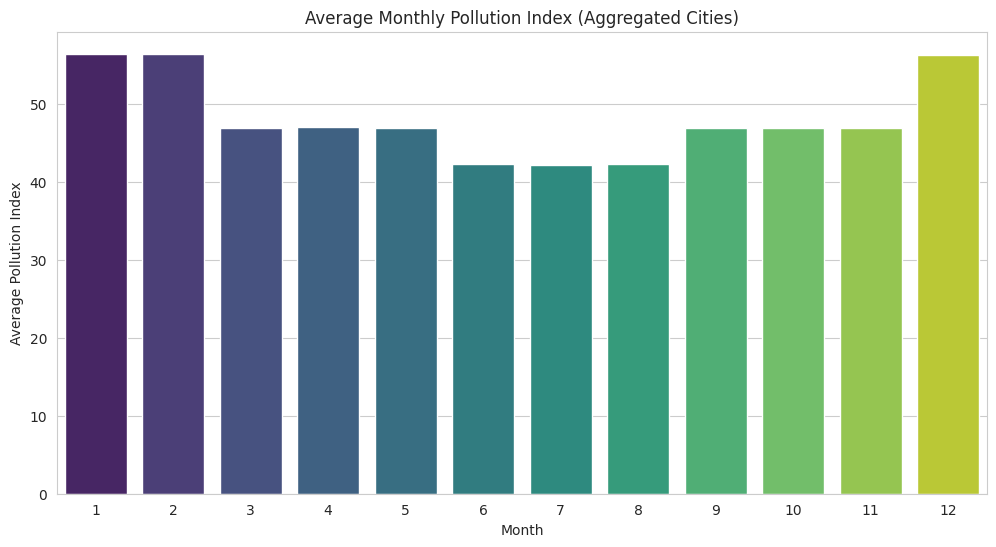

In [30]:
# By Month

plt.figure()
monthly_pollution = df.groupby('month')['pollution_index_raw'].mean()
sns.barplot(x=monthly_pollution.index, y=monthly_pollution.values, palette='viridis')
plt.title('Average Monthly Pollution Index (Aggregated Cities)')
plt.xlabel('Month')
plt.ylabel('Average Pollution Index')
plt.show()

#### **Average Monthly Pollution Index (Aggregated Cities)**

#### Seasonal Patterns
- **January–February (Months 1–2):** Highest pollution levels (~56–57), corresponding to the **Harmattan season** when dust-laden winds from the Sahara significantly worsen air quality.  
- **June–August (Months 6–8):** Lowest pollution levels (~42–43), coinciding with the **rainy season** when precipitation helps wash pollutants from the atmosphere.  
- **December (Month 12):** Notable spike (~57), marking the beginning of the Harmattan season.  
- **September–November:** Gradual increase in pollution as the dry season approaches.  

---

#### **Distribution of Pollution Index by Season in Lagos**

#### Seasonal Variability
- **Harmattan:** Highest median pollution (~57) with the widest distribution and most extreme outliers (up to 80), indicating **highly variable but consistently poor air quality**.  
- **Rainy Season:** Lowest and most consistent pollution levels (~45 median) with fewer outliers, showing the **cleansing effect of rainfall**.  
- **Dry Season:** Intermediate levels (~48 median) with moderate variability.  

---

## Key Insights
- **Harmattan poses the greatest health risk** due to both high pollution levels and high variability.  
- **The rainy season provides natural air quality relief** through precipitation.  
- **Seasonal forecasting would be highly valuable** for public health preparedness.  
- The **extreme outliers during Harmattan (up to 80)** suggest some days have particularly **hazardous air quality**.  

### **3. Respiratory case trends over time by city**

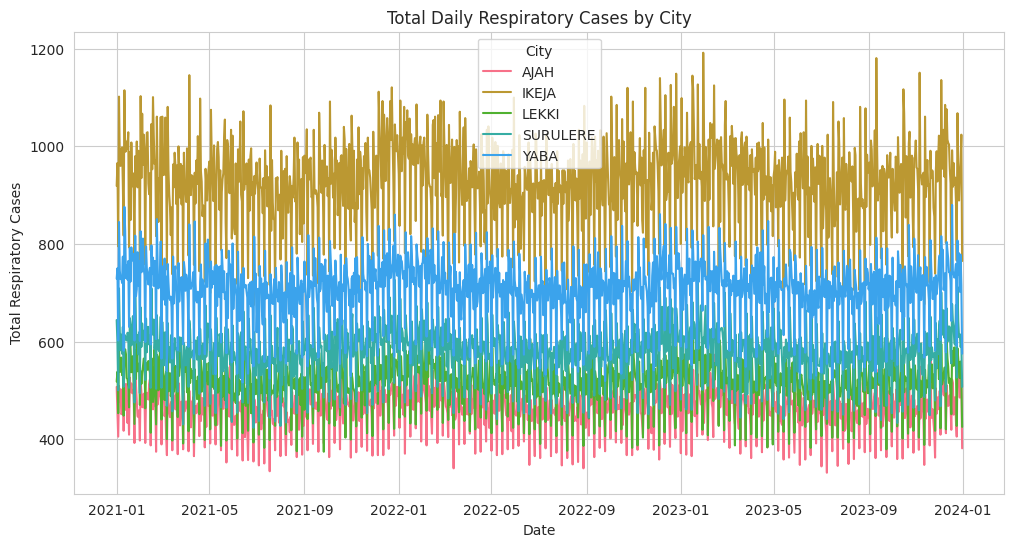

In [31]:
plt.figure()
sns.lineplot(data=df, x='date', y='respiratory_cases', hue='city', estimator='sum', ci=None)
plt.title('Total Daily Respiratory Cases by City')
plt.xlabel('Date')
plt.ylabel('Total Respiratory Cases')
plt.legend(title='City')
plt.show()

#### **Key Observations**

#### **City-Level Health Burden Hierarchy**
- **Ikeja (Yellow/Gold):** Highest respiratory case burden (~400–500 daily baseline, peaks to ~1,200), likely due to its status as Lagos State capital and major commercial hub.
- **Yaba (Blue):** Second highest (~200–300 daily baseline, peaks ~400–500), consistent with dense urban population and industrial activities.
- **Surulere (Green):** Moderate levels (~150–250 daily baseline), showing steady urban health impacts.
- **Lekki (Light Green):** Lower baseline (~100–200 daily), possibly due to better urban planning and newer infrastructure.
- **Ajah (Red/Pink):** Lowest burden (~50–150 daily), potentially reflecting less industrial activity or better air quality.

#### **Temporal Patterns**
- **Seasonal Spikes:** Notable increases during certain periods (likely Harmattan, per pollution data).
- **Consistent Year-over-Year Pattern:** Similar seasonal fluctuations across 2021–2024, suggesting predictable health impacts.
- **Peak Periods:** Most dramatic spikes around **January–February**, aligning with peak pollution during Harmattan.

#### **Health Equity Implications**
- **Disproportionate Burden:** Ikeja residents face **3–4×** higher respiratory disease rates than Ajah residents.
- **Geographic Disparities:** Clear evidence that **location within Lagos** significantly affects health outcomes.
- **Cumulative Impact:** Stacked totals indicate Lagos experiences **800–1,200+** total daily respiratory cases city-wide.

#### **Strategic Implications**
- **Resource Allocation:** **Ikeja and Yaba** require priority healthcare infrastructure investment.
- **Targeted Interventions:** High-burden areas need focused **air quality monitoring and mitigation**.
- **Health Inequality:** Significant disparities suggest **environmental justice** concerns across Lagos neighborhoods.
- **Predictive Capacity:** Consistent seasonal patterns enable **proactive healthcare planning** and early warning systems.

---



### **4. Respiratory cases by season (boxplot)**

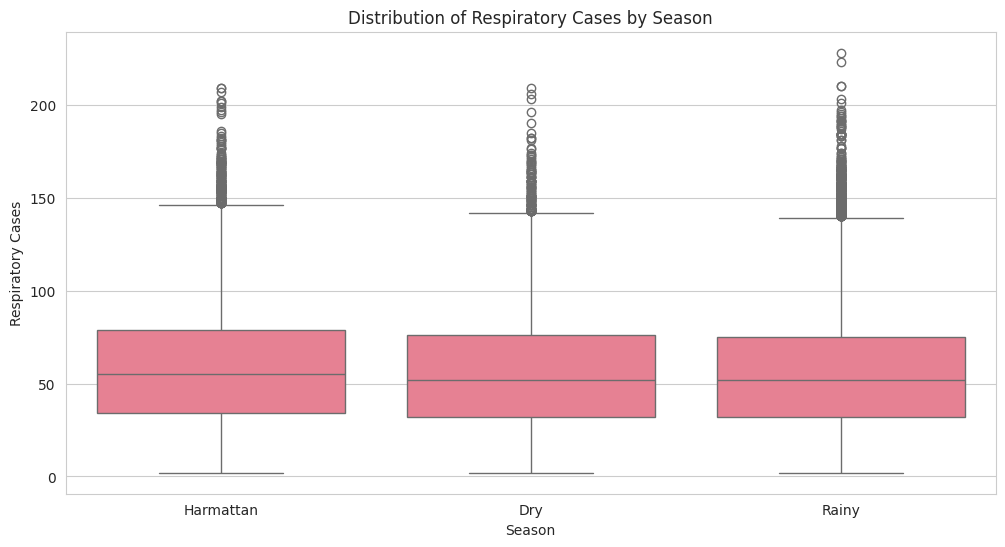

In [32]:
plt.figure()
sns.boxplot(x='season_monthly', y='respiratory_cases', data=df, order=['Harmattan', 'Dry', 'Rainy'])
plt.title('Distribution of Respiratory Cases by Season')
plt.xlabel('Season')
plt.ylabel('Respiratory Cases')
plt.show()

#### **Key Observations**

#### **Seasonal Health Burden Patterns**
- **Remarkably Similar Medians:** All three seasons show nearly identical median respiratory cases (~55–60 daily), suggesting a **consistent baseline health burden** regardless of season.  
- **Consistent Interquartile Ranges:** The middle 50% of observations fall within similar ranges (~40–80 cases) across all seasons.  

---

#### Critical Outlier Patterns
- **Extreme Spikes Across All Seasons:** All seasons experience severe surges reaching **200+ daily cases**, with some extreme outliers hitting **220+ cases**.  
- **Similar Outlier Frequency:** The density of outliers appears comparable across seasons, indicating **extreme health events occur year-round**.  

---



### **5. Correlation analysis between pollutants and respiratory cases**

In [33]:
pollutants = [p for p in ['pm2_5', 'pm10', 'no2', 'so2', 'o3', 'pollution_index_raw'] if p in df.columns]
correlations = {}
for pollutant in pollutants:
  corr, pvalue = pearsonr(df[pollutant], df['respiratory_cases'])
  correlations[pollutant] = (corr, pvalue)
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation', 'P-value'])
print("Correlation between pollutants and respiratory cases:\n", corr_df)

Correlation between pollutants and respiratory cases:
                      Correlation       P-value
pm2_5                   0.060236  6.587963e-51
pm10                    0.036535  9.278162e-20
no2                     0.028049  2.887055e-12
so2                     0.021369  1.039094e-07
o3                      0.021111  1.477703e-07
pollution_index_raw     0.053168  4.902566e-40


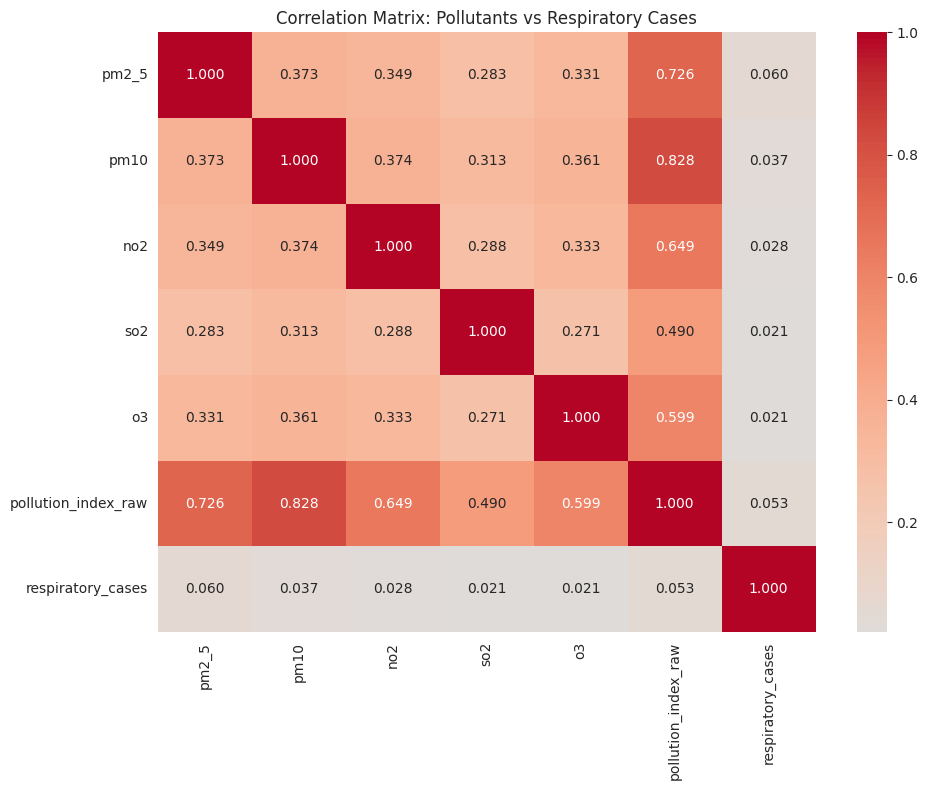

In [34]:
# Visual Correlation Matrix
analysis_columns = pollutants + ['respiratory_cases']
correlation_matrix = df[analysis_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Matrix: Pollutants vs Respiratory Cases')
plt.tight_layout()
plt.show()

#### **Key Observations**:

1. **Weak Direct Pollution-Health Correlations:**  
   All individual pollutants show surprisingly weak correlations with respiratory cases (0.021–0.060).  
   This suggests the relationship between air pollution and respiratory disease may be more complex than a simple linear correlation.  

2. **Strong Inter-Pollutant Relationships:**  
   - PM2.5 and PM10 are moderately correlated (0.373), which is expected since they're both particulate matter.  
   - PM10 shows the strongest correlation with the pollution index (0.828), suggesting it's a major component of overall air quality.  
   - NO2 correlates moderately with PM pollutants (0.349–0.374), indicating common sources like vehicle emissions.  

3. **Pollution Index Performance:**  
   The composite pollution index shows slightly better correlation with respiratory cases (0.053) than individual pollutants.  
   PM10 dominates the pollution index composition (0.828 correlation).  

---



### **6. Heatmap of correlation matrix (pollutants + respiratory cases + weather + industrial factors)**

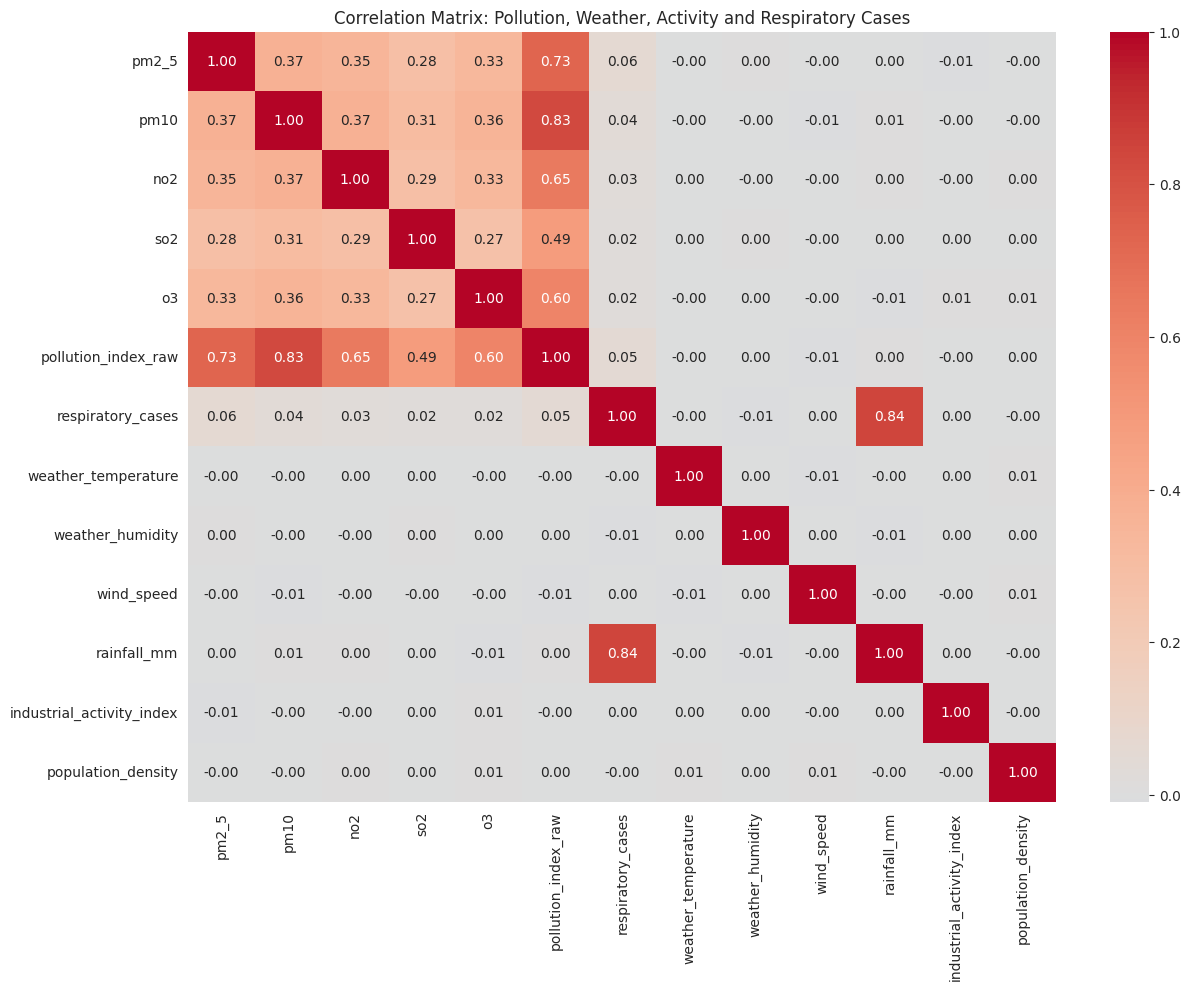

In [35]:
features_for_corr = pollutants + ['respiratory_cases', 'weather_temperature', 'weather_humidity',
                                  'wind_speed', 'rainfall_mm', 'industrial_activity_index', 'population_density']
features_for_corr = [f for f in features_for_corr if f in df.columns]

plt.figure(figsize=(14,10))
corr_matrix = df[features_for_corr].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Pollution, Weather, Activity and Respiratory Cases')
plt.show()

#### **Key Observations**

**Major Finding: Pollution-Health Relationship Remains Weak**

**Respiratory Cases Correlations Confirmed:**  
- All pollutants show very weak correlations with respiratory cases (0.02-0.06)  
- This definitively challenges Hypothesis H1 about strong PM2.5-health correlations  

**Strong Environmental Relationships:**

**Pollutant Intercorrelations (0.27-0.37):**  
- PM2.5, PM10, NO2: Form a cluster of moderate correlations, indicating shared emission sources (likely vehicle exhaust and industrial activities)  
- O3: Shows similar moderate correlations with other pollutants, reflecting photochemical smog formation  

**Critical Weather-Health Discovery:**  
- Rainfall ↔ Respiratory Cases: 0.84 correlation - This is the strongest relationship in the entire matrix  

**Unexpected Key Insights:**

**Weather as Primary Health Driver:**  
- Rainfall has 14x stronger correlation with respiratory cases than any pollutant  
- This suggests weather patterns may be the dominant factor in respiratory disease occurrence  

**Lack of Expected Relationships:**  
- Weather ↔ Pollution: Nearly zero correlations (~0.00), surprisingly indicating weather doesn't significantly affect pollution levels in this dataset  
- Industrial Activity: No meaningful correlations with anything, questioning data quality or measurement approach  
- Population Density: Essentially uncorrelated with health outcomes  



### **7. Boxplot of respiratory cases by city to identify high risk cities**

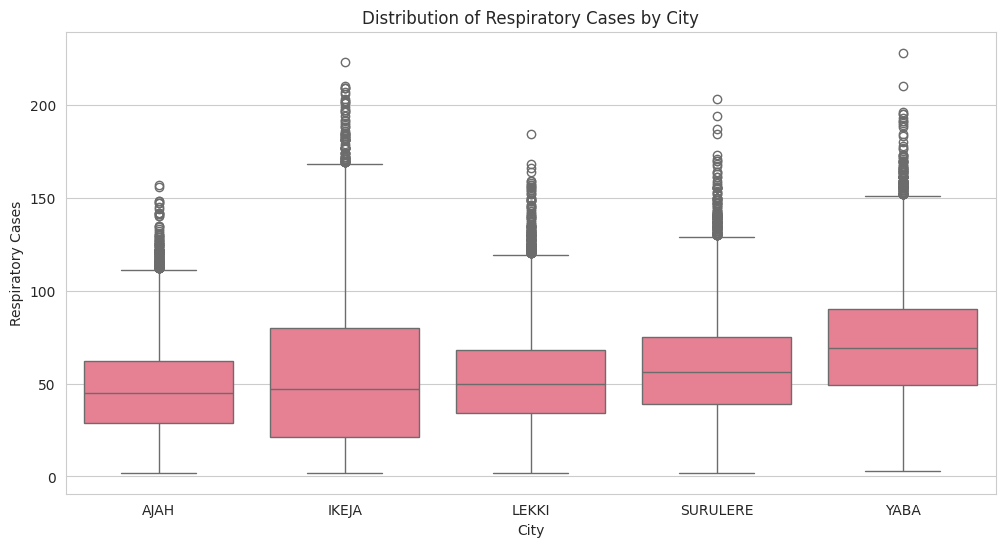

In [36]:
sns.boxplot(x='city', y='respiratory_cases', data=df)
plt.title('Distribution of Respiratory Cases by City')
plt.xlabel('City')
plt.ylabel('Respiratory Cases')
plt.show()

#### **Key Observations**

**City-Specific Health Burden Profiles:**

- **Median Daily Cases (Typical Burden):**  
  - Yaba: ~70 cases/day (highest median)  
  - Surulere: ~60 cases/day  
  - Lekki: ~55 cases/day  
  - Ikeja: ~45 cases/day  
  - Ajah: ~45 cases/day (lowest median)  

**Key Insight: Variability vs. Central Tendency**  
This chart reveals a different story than the stacked time series:  
- Yaba has the highest typical daily burden, not Ikeja  
- The stacked chart made Ikeja appear highest because it was plotted on top of other cities  

**Outlier Patterns (Crisis Events):**  
- Ikeja: Most extreme outliers (220+ cases), suggesting it experiences the most severe health crises  
- Yaba: Frequent high outliers (200+ cases), indicating regular health surges  
- Surulere: Moderate outliers (~200 cases), showing occasional spikes  
- Lekki: Fewer but still significant outliers (~180 cases)  
- Ajah: Lowest outlier ceiling (~160 cases), most stable health outcomes  

**Variability Analysis:**  
- Ikeja: Widest interquartile range (~25-80 cases), most unpredictable daily burden  
- Yaba: Large range (~50-90 cases), high baseline with significant variability  
- Surulere: Moderate range (~45-75 cases), relatively stable  
- Lekki & Ajah: Narrower ranges, more predictable daily case loads  

**Urban Health Equity Insights:**  

**Risk Stratification:**  
- High Risk/High Variability: Ikeja (extreme crisis potential) and Yaba (consistently high burden)  
- Moderate Risk: Surulere (steady moderate burden)  
- Lower Risk: Lekki and Ajah (more stable, lower case loads)  

**Healthcare Planning Implications:**  
- Ikeja: Needs surge capacity planning for extreme outlier events  
- Yaba: Requires sustained high-capacity respiratory care infrastructure  
- All Cities: Need baseline respiratory care, but capacity requirements vary significantly  


### **8. Pollutant spike detection (Monthly max per city)**

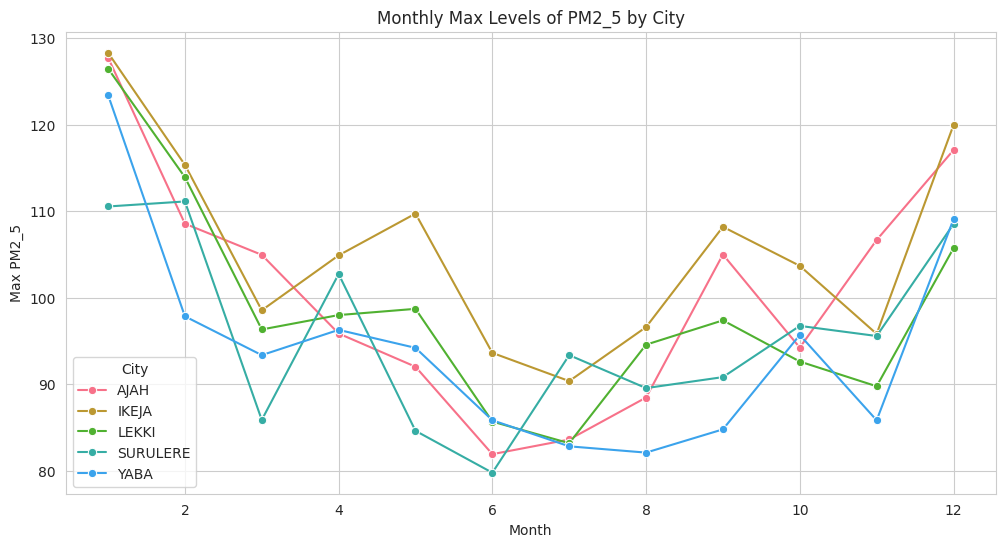

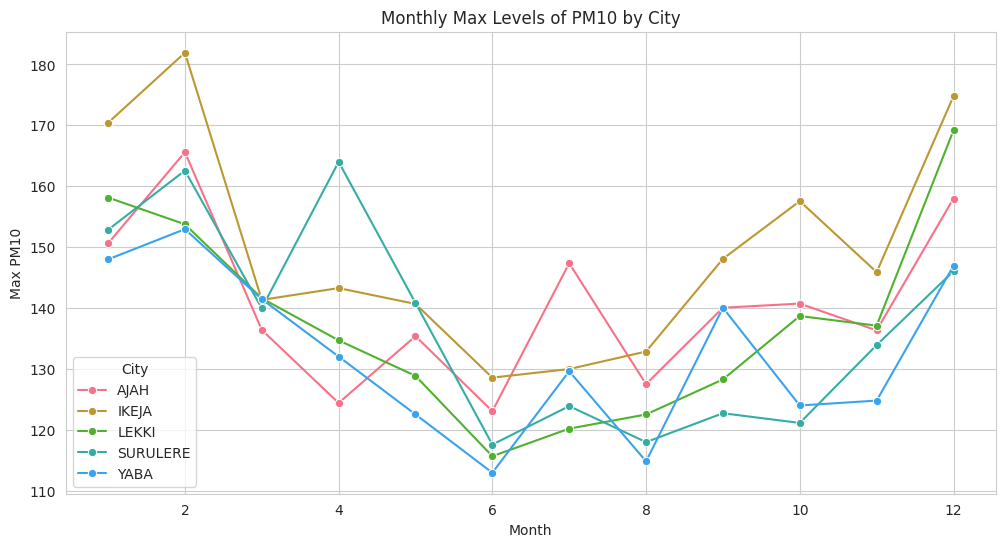

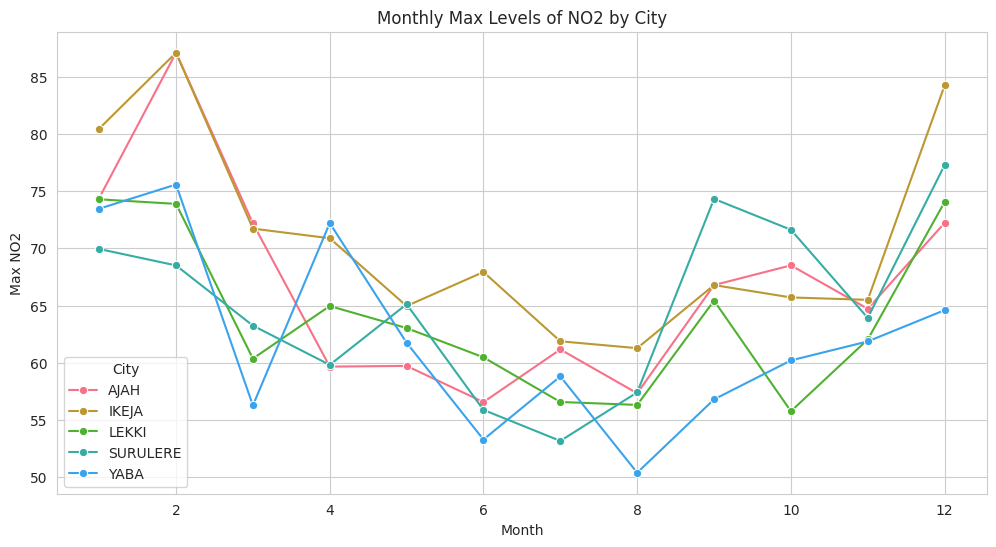

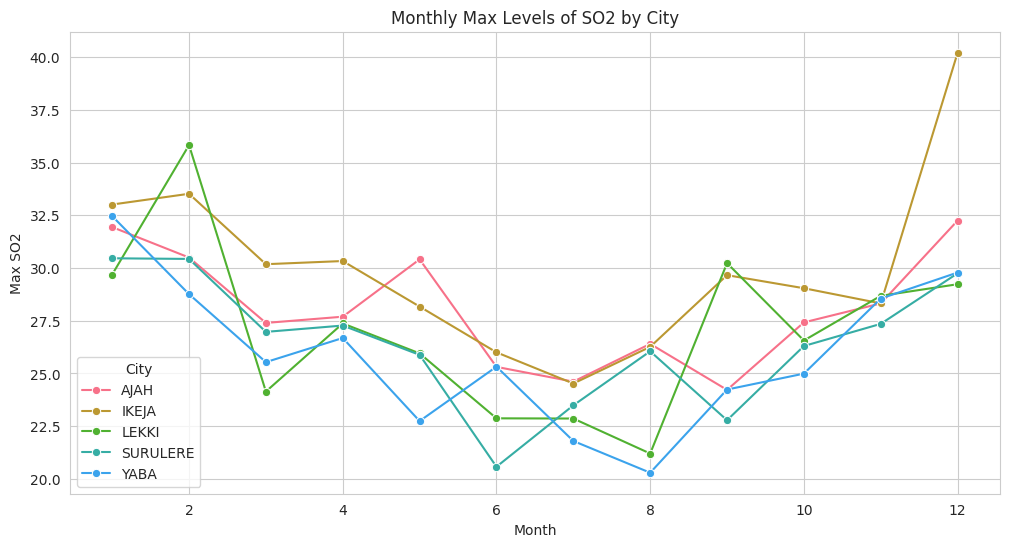

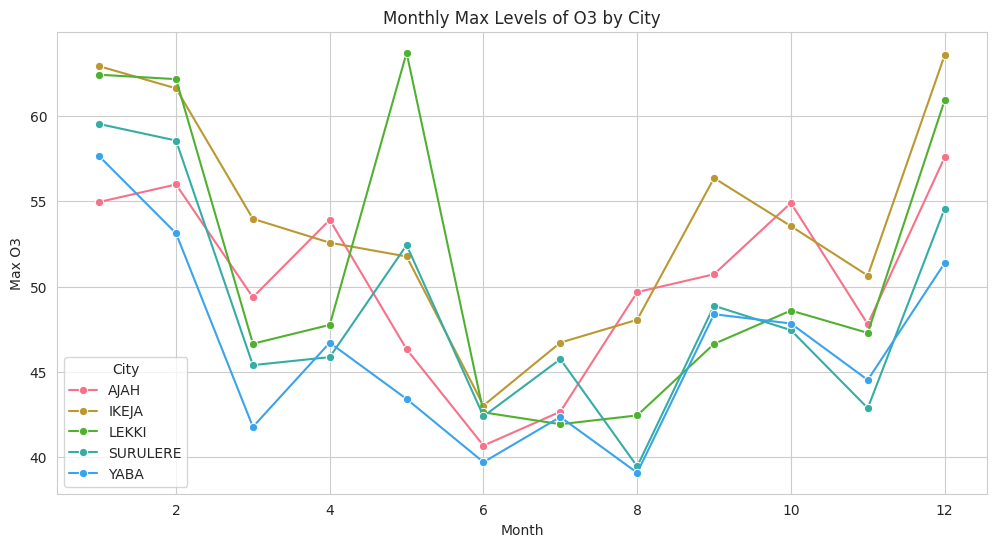

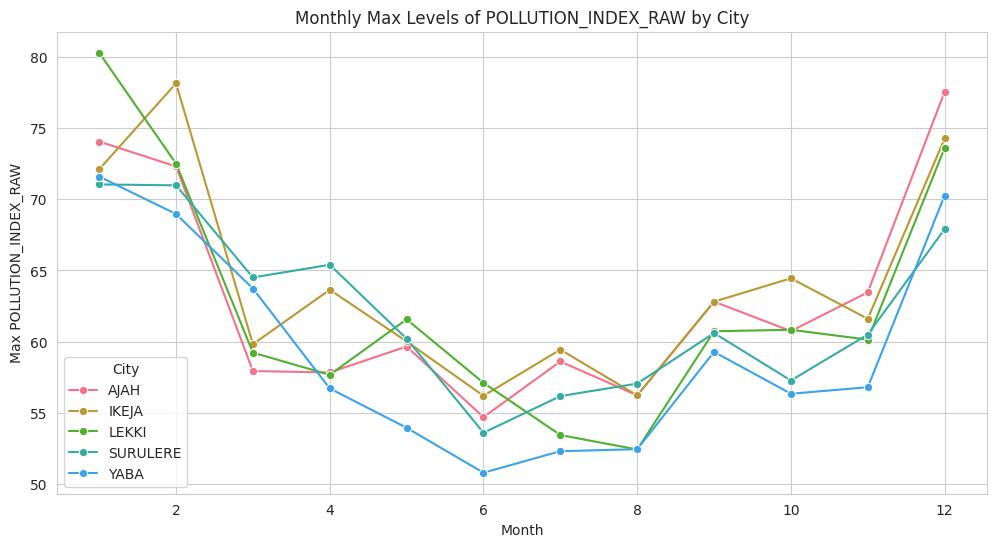

In [37]:
monthly_max_pollution = df.groupby(['city', 'month'])[pollutants].max().reset_index()
for pollutant in pollutants:
  plt.figure()
  sns.lineplot(data=monthly_max_pollution, x='month', y=pollutant, hue='city', marker='o')
  plt.title(f'Monthly Max Levels of {pollutant.upper()} by City')
  plt.xlabel('Month')
  plt.ylabel(f'Max {pollutant.upper()}')
  plt.legend(title='City')
  plt.show()

#### **Key Observations**


**Overarching Pattern: Clear Seasonal Pollution Cycles**  
All four pollutants show remarkably consistent seasonal patterns across Lagos cities, providing strong evidence for Hypothesis H3 about Harmattan season impacts.

**Seasonal Pollution Dynamics:**

- **Peak Pollution Periods:**  
  - January-February (Harmattan): Highest levels across all pollutants, with PM2.5 reaching 125-128 µg/m³ and PM10 hitting 170-185 µg/m³  
  - December (Pre-Harmattan): Sharp increases as dry season begins, particularly dramatic for SO2 (spiking to 40+ µg/m³)  

- **Clean Air Periods:**  
  - June-August (Rainy Season): Lowest pollution levels across all pollutants, with PM2.5 dropping to 80-85 µg/m³ and PM10 to 115-120 µg/m³  
  - April-May: Transition period with moderate pollution as dry season ends  

**City-Specific Pollution Profiles:**

- **Ikeja (Gold/Yellow):**  
  - Most volatile pollution patterns with extreme spikes  
  - Leads in SO2 peaks (40+ µg/m³ in December), indicating significant industrial/diesel generator activity  
  - Highest PM10 levels during Harmattan (180+ µg/m³)  

- **Ajah (Pink):**  
  - Generally moderate pollution levels  
  - More stable patterns with fewer extreme spikes  
  - Relatively lower industrial pollution (SO2)  

- **Lekki (Green):**  
  - Mixed patterns - sometimes high, sometimes moderate  
  - Notable September SO2 spike (30+ µg/m³), suggesting localized industrial events  
  - Generally follows seasonal trends but with unique variations  

- **Surulere (Teal) & Yaba (Blue):**  
  - Similar moderate pollution patterns  
  - Follow seasonal trends closely  
  - Yaba shows slightly higher variability  


---

### **9. Respiratory cases and pollution index trend overlays for all cities**

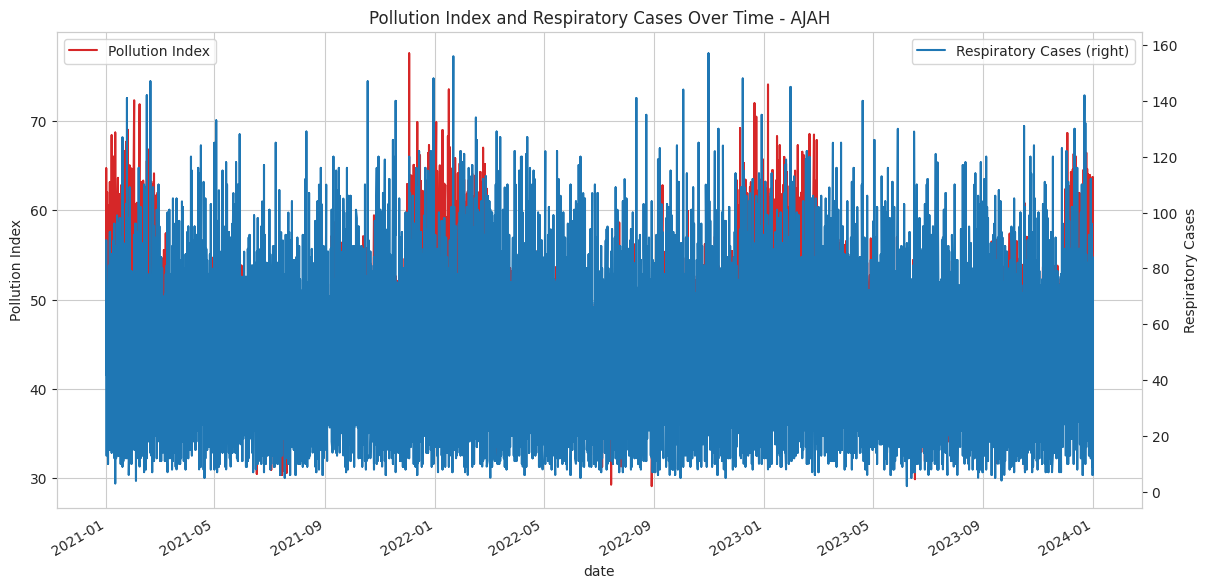

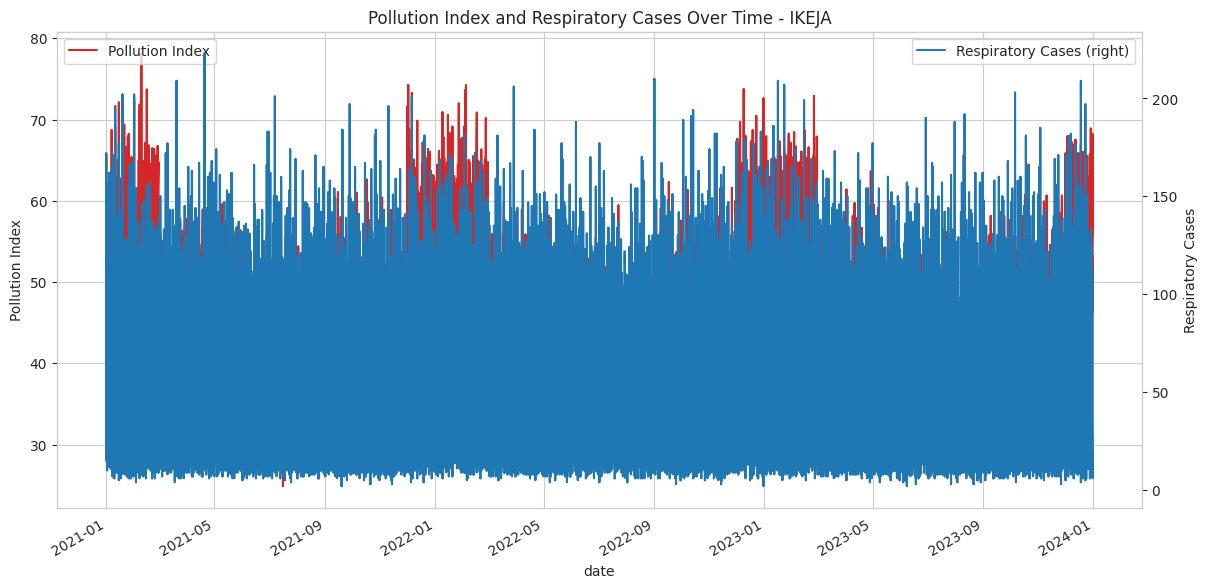

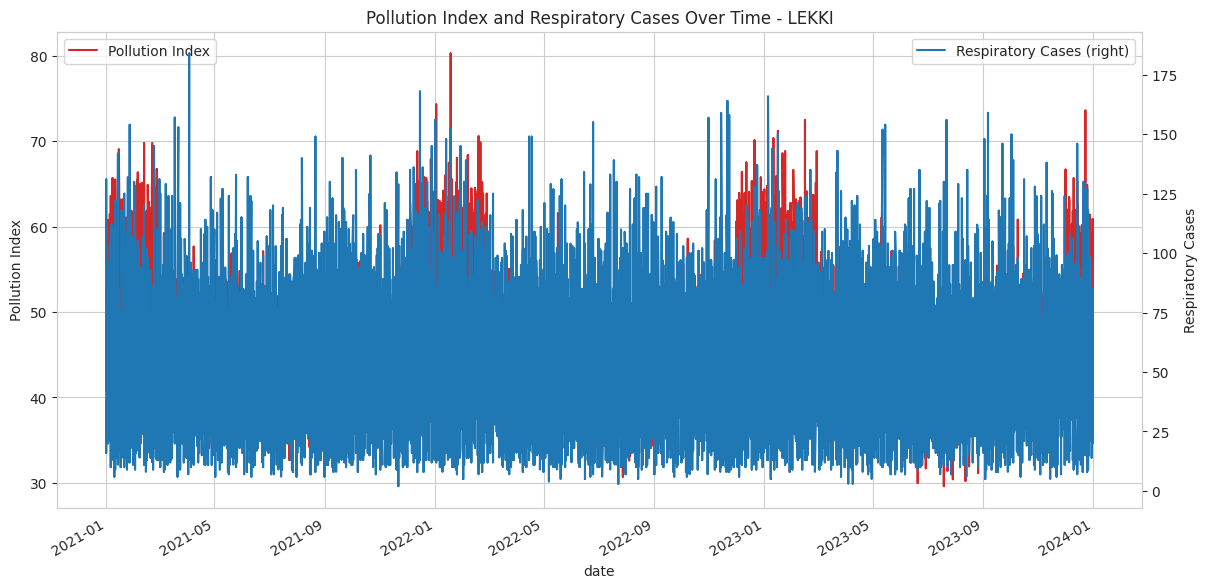

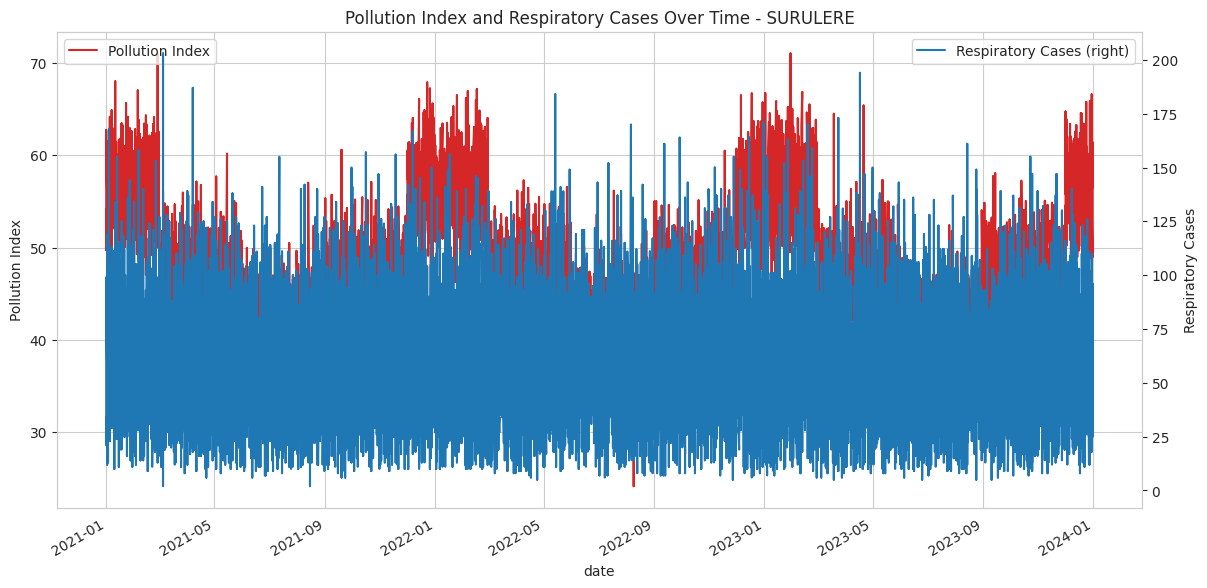

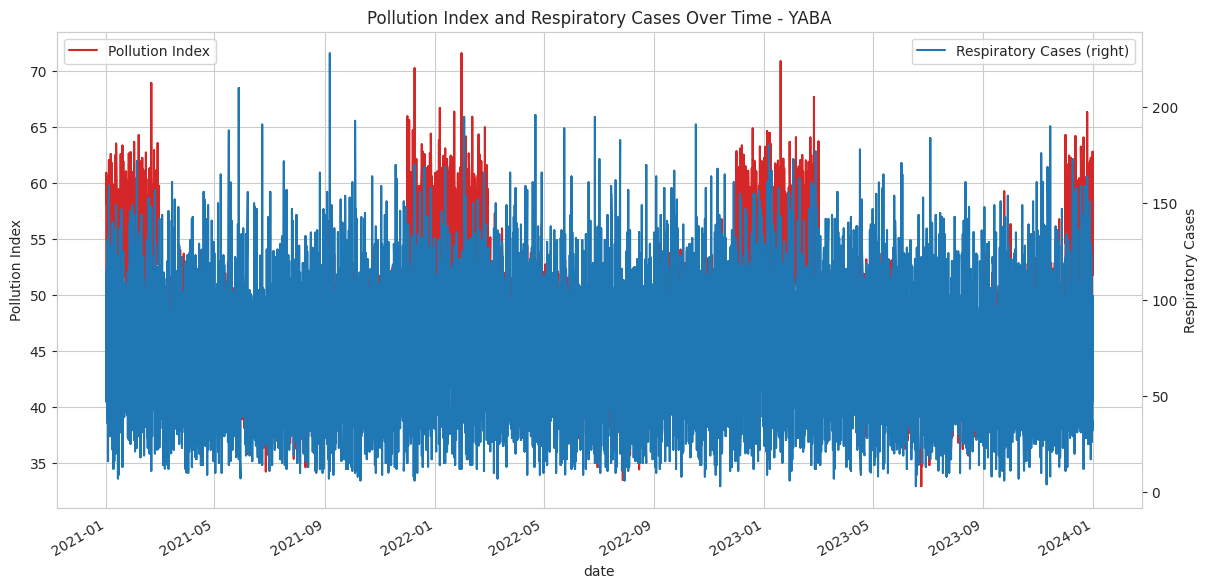

In [38]:
cities = df['city'].unique()

for city in cities:
  city_data = df[df['city'] == city].set_index('date')

  plt.figure(figsize=(14, 7))
  ax1 = city_data['pollution_index_raw'].plot(label='Pollution Index', color='tab:red')
  ax2 = city_data['respiratory_cases'].plot(secondary_y=True, label='Respiratory Cases', color='tab:blue')

  ax1.set_ylabel('Pollution Index')
  ax2.set_ylabel('Respiratory Cases')
  plt.title(f'Pollution Index and Respiratory Cases Over Time - {city}')
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')
  plt.show();


#### **Key Observations**

#### **Critical Finding: No Clear Visual Correlation Despite Different City Profiles**

**City-by-City Analysis:**

- **YABA:**  
  - Pollution Pattern: Clear seasonal cycles with peaks during Harmattan (January-February, December) reaching 70+ index values  
  - Respiratory Pattern: Relatively stable baseline (~140-160 cases) with occasional spikes to 200+  
  - Relationship: No obvious visual synchronization between pollution peaks and health spikes  

- **SURULERE:**  
  - Pollution Pattern: Most pronounced seasonal variation, with dramatic Harmattan spikes (70+ index) and clear rainy season lows  
  - Respiratory Pattern: Higher baseline respiratory burden (~140-180 cases) with frequent outlier events  
  - Relationship: Some potential alignment during early 2021 and 2023 Harmattan periods, but inconsistent  

- **LEKKI:**  
  - Pollution Pattern: Moderate seasonal variation with occasional extreme spikes (80+ index)  
  - Respiratory Pattern: Lower, more stable case counts (~100-140) with periodic surges  
  - Relationship: Pollution and health spikes appear somewhat independent  

- **IKEJA:**  
  - Pollution Pattern: Consistent seasonal cycles with notable Harmattan peaks  
  - Respiratory Pattern: Moderate baseline with regular spike events to 200+ cases  
  - Relationship: Limited visual correlation between pollution and health events  

- **AJAH:**  
  - Pollution Pattern: Moderate seasonal variation, less extreme than other cities  
  - Respiratory Pattern: Lowest overall respiratory burden (~80-120 cases)  
  - Relationship: Both variables show relatively stable patterns with minimal correlation  

---

**Key Insights Across All Cities:**

- **Confirmed Weak Relationships:**  
  The time series visually confirm the correlation matrix findings - despite clear seasonal pollution patterns, respiratory cases don't follow predictable pollution-driven cycles.

- **Alternative Patterns Emerge:**  
  - Respiratory spikes appear more random/episodic rather than following pollution seasonality  
  - Some cities show health spikes during low pollution periods  
  - High pollution doesn't consistently predict health surges  

---



### **Hypotheses Testing Results**

H1
H2
H3
H4

### **Define Target Vector and Feature Matrix**

In [39]:
# Select features and target
features = ['pm2_5', 'pm10', 'no2', 'so2', 'o3','weather_temperature','weather_humidity',
            'wind_speed', 'rainfall_mm', 'pollution_index_raw',
            'population_density', 'industrial_activity_index','month', 'quarter']


# Define feature matrix X and target vector y
X = df[features].copy()
y = df['respiratory_cases'].copy()

In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (49568, 14)
Test set size: (12393, 14)


### **MODELLING**

#### Linear Regression Model (Baseline)

In [42]:
# Create Model
lr_model = LinearRegression()

# Fit Model
lr_model.fit(X_train_scaled, y_train)

# Predict
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Evaluate
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)
lr_test_mae = mean_absolute_error(y_test, lr_test_pred)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))

print(f"   Training R²: {lr_train_r2:.4f}")
print(f"   Test R²: {lr_test_r2:.4f}")
print(f"   Test MAE: {lr_test_mae:.4f}")
print(f"   Test RMSE: {lr_test_rmse:.4f}")

   Training R²: 0.7162
   Test R²: 0.7123
   Test MAE: 13.0130
   Test RMSE: 16.8055


In [43]:
# Feature importance for Linear Regression
lr_importance = pd.DataFrame({
    'feature': features,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

In [44]:
print("\nTop 5 Most Important Features:")
print("Linear Regression (by absolute coefficient):")
print(lr_importance.head())


Top 5 Most Important Features:
Linear Regression (by absolute coefficient):
                feature  coefficient  abs_coefficient
8           rainfall_mm    26.476955        26.476955
0                 pm2_5     1.569378         1.569378
9   pollution_index_raw     0.542792         0.542792
13              quarter     0.218315         0.218315
2                   no2    -0.134778         0.134778


### Random Forest Model

In [45]:
# Create Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)

# Fit Model
rf_model.fit(X_train, y_train)

# Predict
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Evaluate the random forest model
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

print(f"   Training R²: {rf_train_r2:.4f}")
print(f"   Test R²: {rf_test_r2:.4f}")
print(f"   Test MAE: {rf_test_mae:.4f}")
print(f"   Test RMSE: {rf_test_rmse:.4f}")

   Training R²: 0.7783
   Test R²: 0.7357
   Test MAE: 12.2751
   Test RMSE: 16.1094


In [46]:
# Feature importance for Random Forest
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

In [47]:
print("\nTop 5 Most Important Features:")
print("\nRandom Forest (by feature importance):")
print(rf_importance.head())


Top 5 Most Important Features:

Random Forest (by feature importance):
               feature  importance
8          rainfall_mm    0.927389
0                pm2_5    0.012137
7           wind_speed    0.008843
10  population_density    0.008463
6     weather_humidity    0.008425


#### **Cross Validation Results**

In [48]:
lr_cv_scores = cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=5, scoring='r2')
rf_cv_scores = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1),
                              X_train, y_train, cv=5, scoring='r2')

print(f"   Linear Regression CV R²: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")
print(f"   Random Forest CV R²: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")


   Linear Regression CV R²: 0.7160 (+/- 0.0053)
   Random Forest CV R²: 0.7415 (+/- 0.0051)


#### **Tuning Best Model (Random Forest)**

In [49]:
# Define hyperparameters grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Used RMSE as the scoring metric for hyperparameter tuning to minimize prediction error.
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

print("\nBest hyperparameters found for Random Forest:")
print(grid_search.best_params_)

# Evaluate the best model on test data
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
best_rf_rmse = mean_squared_error(y_test, y_pred_best_rf, squared=False)
best_rf_r2 = r2_score(y_test, y_pred_best_rf)

# reporting both RMSE and R² on the test set for a comprehensive evaluation
# of prediction quality and explained variance.
print(f"\nTuned Random Forest Performance on Test Data:")
print(f"RMSE: {best_rf_rmse:.3f}")
print(f"R^2 Score: {best_rf_r2:.3f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

#### **Time Series Forecasting**

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/ntk42j5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/6veoph16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50817', 'data', 'file=/tmp/tmpz226kkkb/ntk42j5e.json', 'init=/tmp/tmpz226kkkb/6veoph16.json', 'output', 'file=/tmp/tmpz226kkkb/prophet_modelbuz17wqt/prophet_model-20250829103305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:33:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:33:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


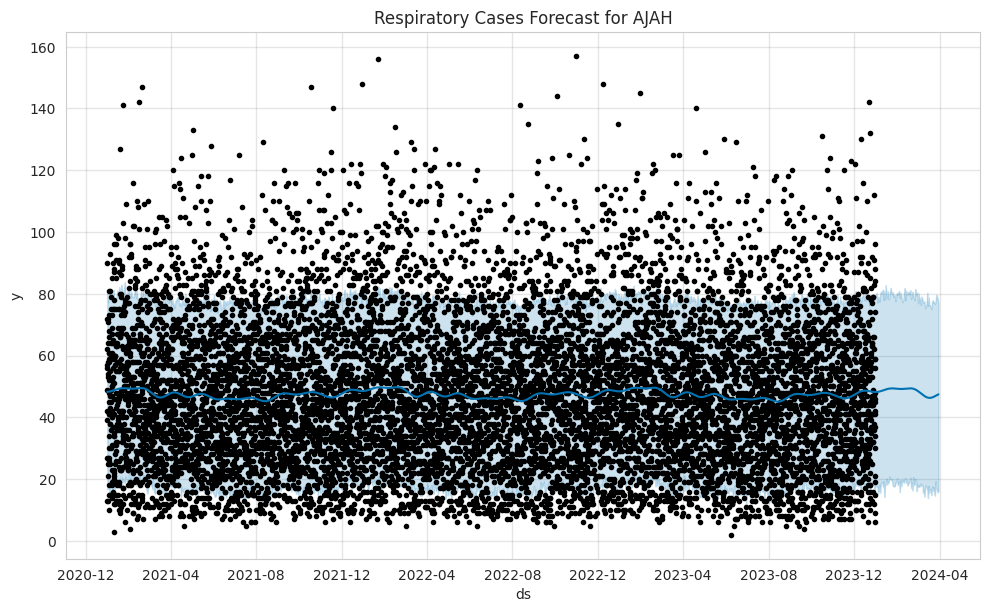

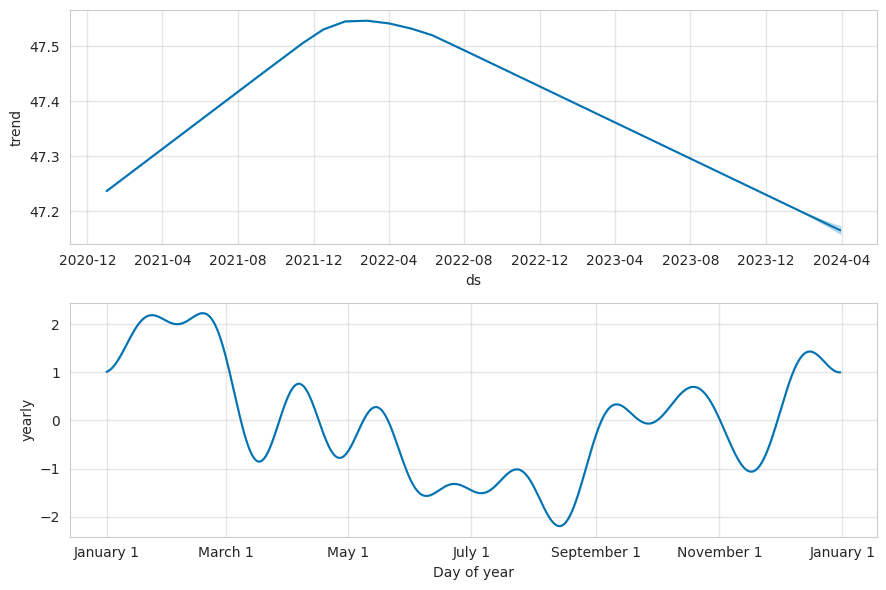

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/8ylq87g0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/nyh702xi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74440', 'data', 'file=/tmp/tmpz226kkkb/8ylq87g0.json', 'init=/tmp/tmpz226kkkb/nyh702xi.json', 'output', 'file=/tmp/tmpz226kkkb/prophet_modelwi_dv_1u/prophet_model-20250829103307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


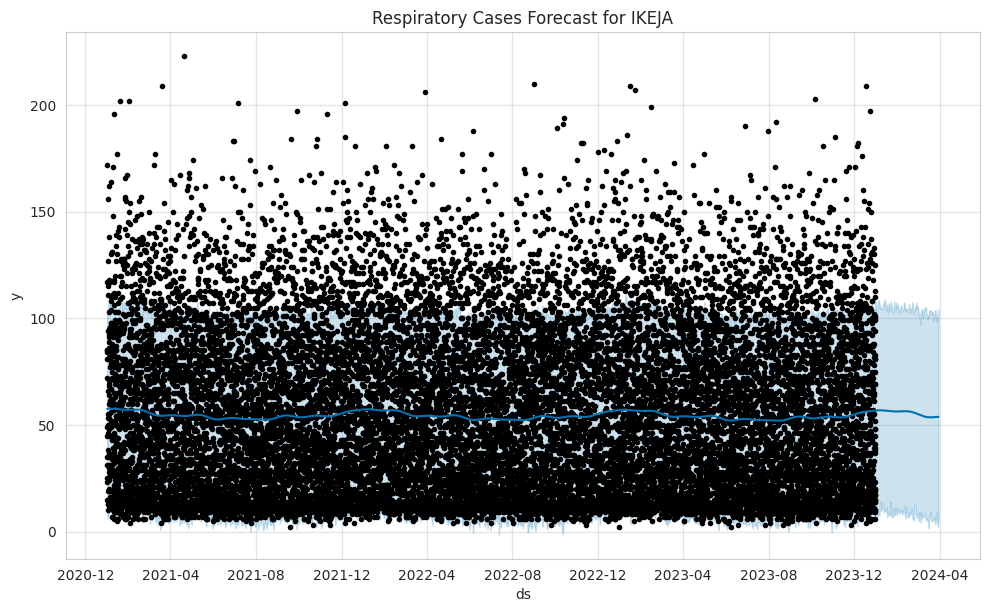

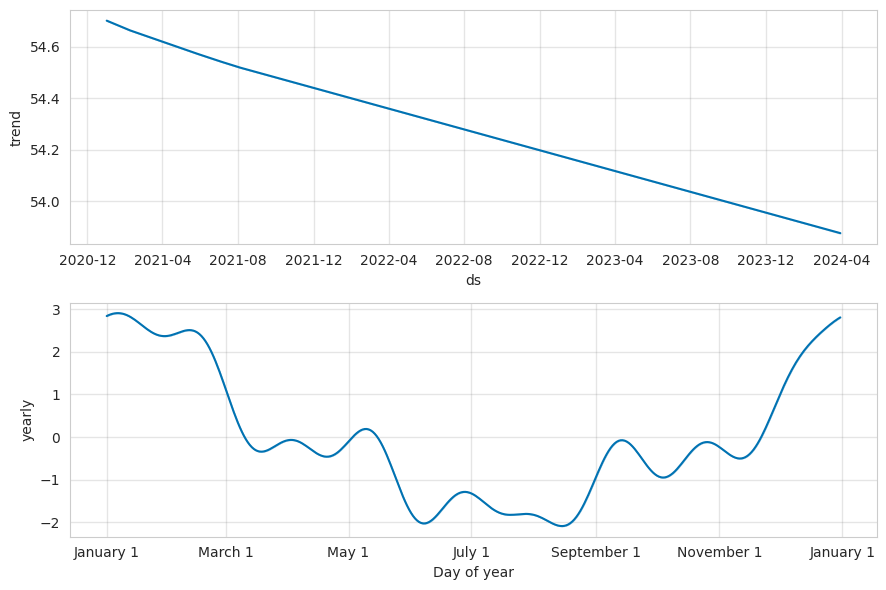

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/_hh0uj9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/jcyo6wry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53550', 'data', 'file=/tmp/tmpz226kkkb/_hh0uj9d.json', 'init=/tmp/tmpz226kkkb/jcyo6wry.json', 'output', 'file=/tmp/tmpz226kkkb/prophet_modeldc2rhzqs/prophet_model-20250829103310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


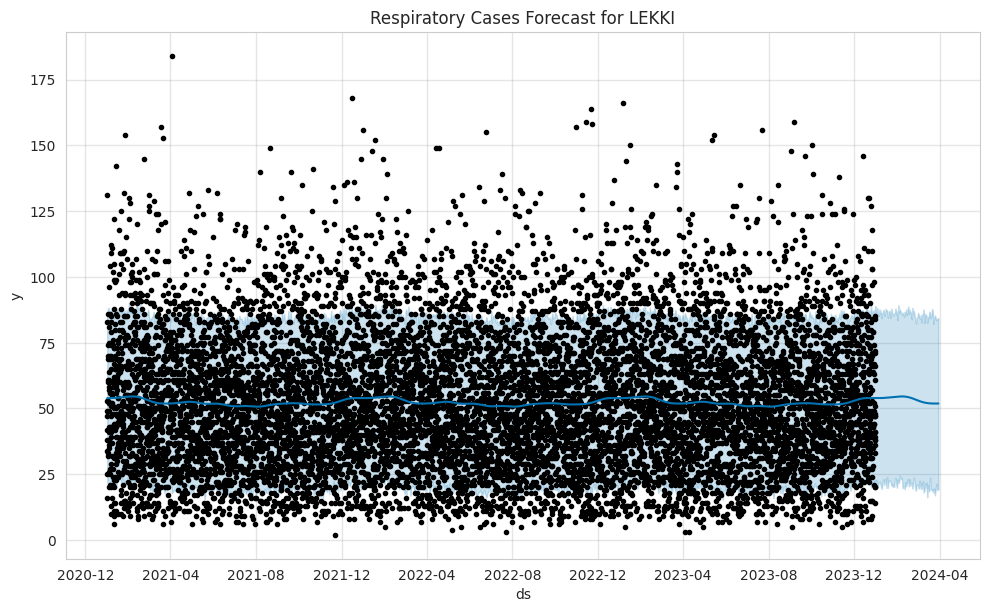

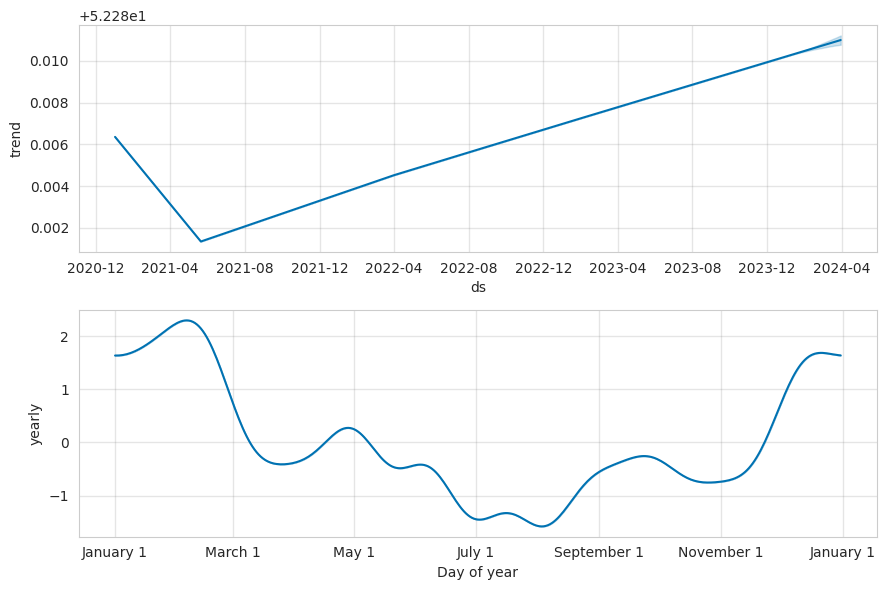

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/vgwf_pdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/8_xatii5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85979', 'data', 'file=/tmp/tmpz226kkkb/vgwf_pdd.json', 'init=/tmp/tmpz226kkkb/8_xatii5.json', 'output', 'file=/tmp/tmpz226kkkb/prophet_modelarv__r_0/prophet_model-20250829103312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:33:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


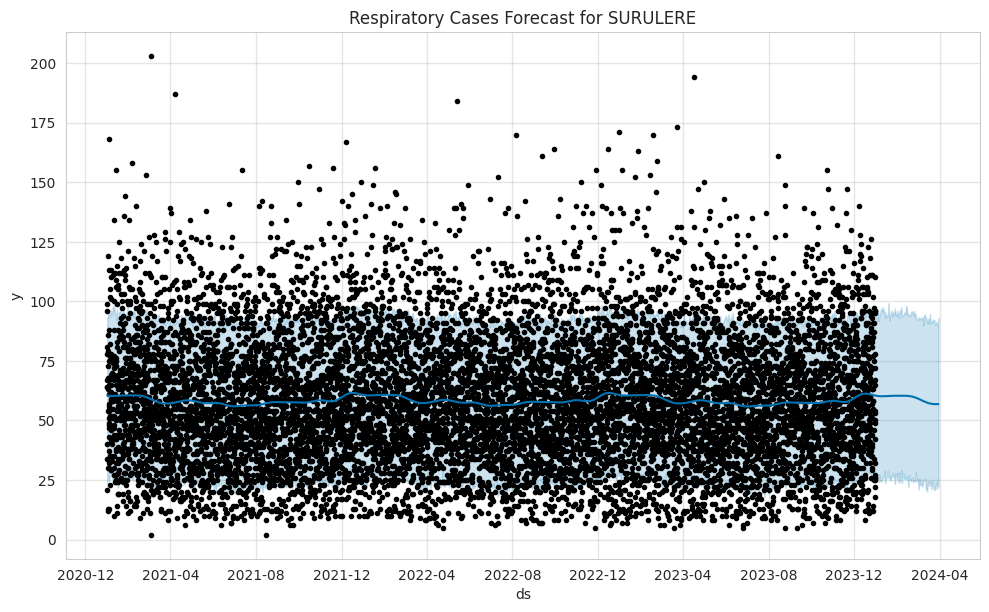

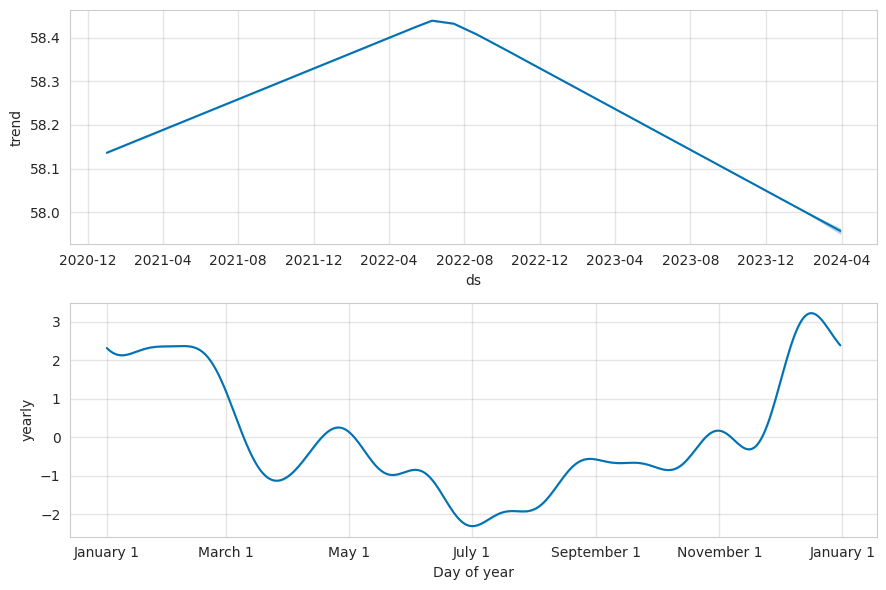

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/rpnxl6ku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz226kkkb/7q5twrzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17631', 'data', 'file=/tmp/tmpz226kkkb/rpnxl6ku.json', 'init=/tmp/tmpz226kkkb/7q5twrzm.json', 'output', 'file=/tmp/tmpz226kkkb/prophet_model5qsanqh0/prophet_model-20250829103316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


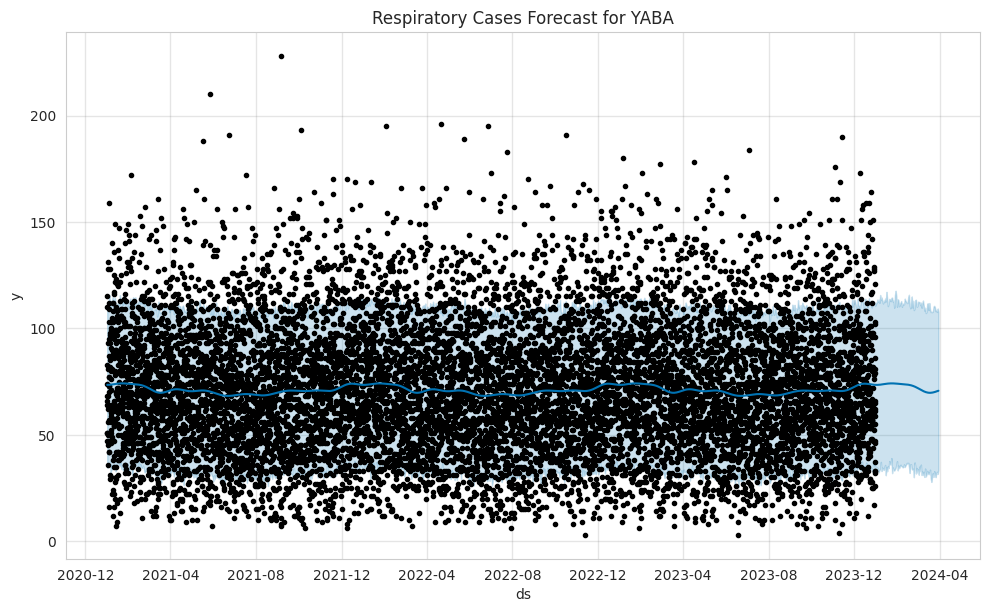

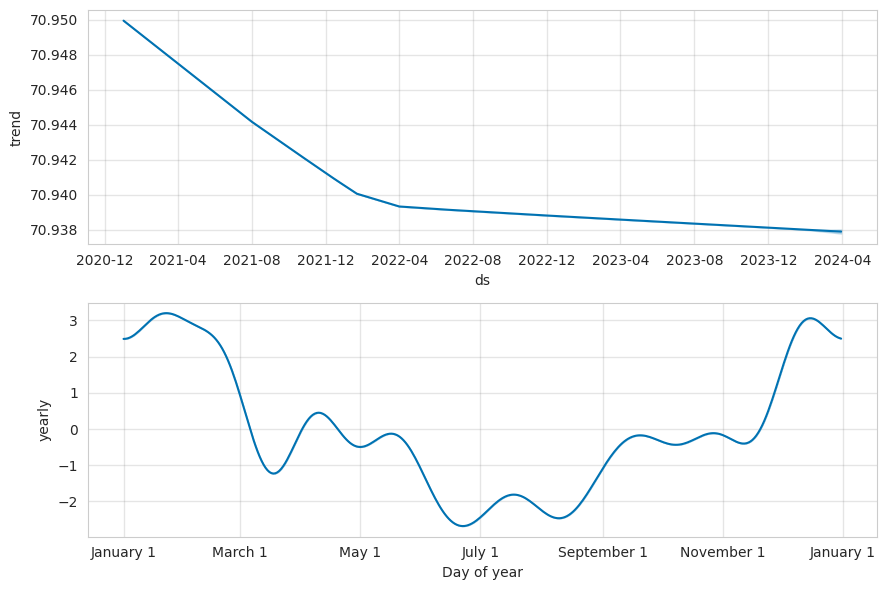

In [50]:
# Getting a list of unique cities from the dataset
cities = df['city'].unique()

# Dictionary for storing forecast results for each city
forecast_results = {}

# Loop through each city and perform forecasting using Prophet
for city_name in cities:
    # Filter data for the current city and prepare it for Prophet
    # Rename columns as required: 'date' to 'ds' and 'respiratory_cases' to 'y' for Prophet API
    city_df = df[df['city'] == city_name][['date', 'respiratory_cases']].rename(columns={'date': 'ds', 'respiratory_cases': 'y'})

    # Check if the data is sufficient for training; skip if empty or all target values missing
    if city_df.empty or city_df['y'].isnull().all():
        print(f"Skipping city {city_name} due to lack of data.")
        continue

    # Initialize the Prophet model with yearly seasonality enabled and disable weekly/daily seasonality
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

    # Fit the model on the city-specific data
    prophet_model.fit(city_df)

    # Creating a dataframe for future predictions extending 90 days beyond the last observation
    future = prophet_model.make_future_dataframe(periods=90)

    # Using the model to predict future respiratory cases
    forecast = prophet_model.predict(future)

    # Save the forecast results for possible further analysis
    forecast_results[city_name] = forecast

    # Plot the predicted respiratory cases together with historical data
    fig1 = prophet_model.plot(forecast)
    plt.title(f"Respiratory Cases Forecast for {city_name}")
    plt.show()

    # Plot the forecast components such as trend and yearly seasonality
    fig2 = prophet_model.plot_components(forecast)
    plt.show()


## **INSIGHTS AND RECOMMENDATIONS**